**Projeto de ML - Crédito Imobiliário - Diolan**

___

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
# splits
from sklearn.model_selection import train_test_split, StratifiedKFold

# Grids
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Metrics
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay

# Estimators
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Enconders
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# Scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Others
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [4]:
sns.set_theme()

# pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.options.display.float_format = '{:,.6f}'.format

# desabilita os warnings
import warnings
warnings.filterwarnings('ignore')

___

## Leitura dos Dados

In [5]:
df = pd.read_csv('./data/application_train.csv')

df = df.drop(columns=['SK_ID_CURR'])

df

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,Cash loans,F,N,N,0,"112,500.000000","700,830.000000","22,738.500000","585,000.000000",...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
1,0,Cash loans,F,N,N,0,"90,000.000000","375,322.500000","14,422.500000","324,000.000000",...,0,0,0,0,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000
2,0,Cash loans,M,Y,N,0,"180,000.000000","544,491.000000","16,047.000000","454,500.000000",...,0,0,0,0,0.000000,0.000000,0.000000,1.000000,1.000000,3.000000
3,0,Cash loans,F,N,Y,0,"270,000.000000","814,041.000000","28,971.000000","679,500.000000",...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
4,0,Cash loans,F,N,Y,0,"144,000.000000","675,000.000000","21,906.000000","675,000.000000",...,0,0,0,0,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246003,0,Cash loans,F,N,Y,1,"270,000.000000","1,172,470.500000","34,411.500000","918,000.000000",...,0,0,0,0,0.000000,0.000000,0.000000,1.000000,0.000000,8.000000
246004,0,Cash loans,F,N,Y,0,"180,000.000000","654,498.000000","27,859.500000","585,000.000000",...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
246005,1,Revolving loans,M,N,N,1,"112,500.000000","270,000.000000","13,500.000000","270,000.000000",...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
246006,1,Cash loans,M,Y,N,3,"202,500.000000","204,858.000000","17,653.500000","171,000.000000",...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


___

## Guardando o target

In [6]:
y = df.TARGET

___

## Retirando Target e Gênero

Aqui vamos retirar a variável genêro (*CODE_GENDER*) para não introduzir viés nos modelos.

In [7]:
X_df = df.drop(columns=['TARGET', 'CODE_GENDER'])

___

## Funções Utilitárias

In [8]:
def predictions_from(model, X):
    return model.predict(X), model.predict_proba(X)[:, 1]

In [9]:
def plot_confusion_martrices(y_train, y_pred_train, y_test, y_pred_test):
    values = {
        'Train': {'true': y_train, 'pred': y_pred_train}, 
        'Test': {'true': y_test, 'pred': y_pred_test} 
    }
       
    fig, axs = plt.subplots(ncols=2, figsize=(11, 5))
    fig.suptitle('Train and Test Confusion Matrices', x=0.2, fontsize=16)
    
    for i, k in enumerate(values.keys()):
        ConfusionMatrixDisplay.from_predictions(values[k]['true'], values[k]['pred'], ax=axs[i])
        axs[i].set_title(k)
        axs[i].grid(False)
    
    plt.tight_layout()
    plt.show()

In [10]:
def plot_roc_curves(y_train, y_proba_train, y_test, y_proba_test):
    data = {
        'Train': {'true': y_train, 'proba': y_proba_train}, 
        'Test': {'true': y_test, 'proba': y_proba_test} 
    }
    
    fig = plt.figure()
    ax = fig.gca()
    
    for k, v in data.items():
        RocCurveDisplay.from_predictions(v['true'], v['proba'], name=k, ax=ax)   
    
    fig.suptitle('Train and Test ROC Curves', x=0.2, fontsize=16)
    plt.tight_layout()
    plt.show()

In [11]:
def print_auc_roc_scores(y_train, y_proba_train, y_test, y_proba_test):
    values = {
        'Train': {'true': y_train, 'proba': y_proba_train}, 
        'Test': {'true': y_test, 'proba': y_proba_test} 
    }
    
    print('\nAUC-ROC Scores:')
    print('-'*15)
    
    for k, v in values.items():
        score = roc_auc_score(values[k]['true'], values[k]['proba'])
        print('{:>5}: {:.4f}'.format(k.upper(), score))

In [12]:
def show_metrics_of(model, X_train, X_test, y_train, y_test):
       
    y_pred_train, y_proba_train = predictions_from(model, X_train)
    
    y_pred_test, y_proba_test = predictions_from(model, X_test)
    
    line = '_'*100
    print(line)
    plot_confusion_martrices(y_train, y_pred_train, y_test, y_pred_test)
    
    print(line)
    plot_roc_curves(y_train, y_proba_train, y_test, y_proba_test)
    
    print(line)
    print_auc_roc_scores(y_train, y_proba_train, y_test, y_proba_test)
    print(line)

___

## Modelagens Inciais

### Regressão Logística com apenas duas features

Vamos começar com a **regressão logística**.

Comecemos com uma regressão bem simples que leva em consideração apenas as variáveis renda total do cliente (*AMT_INCOME_TOTAL*) e valor do crédito (*AMT_CREDIT*).

In [12]:
selected_columns = ['AMT_INCOME_TOTAL', 'AMT_CREDIT']

X = X_df[selected_columns]

____________________________________________________________________________________________________


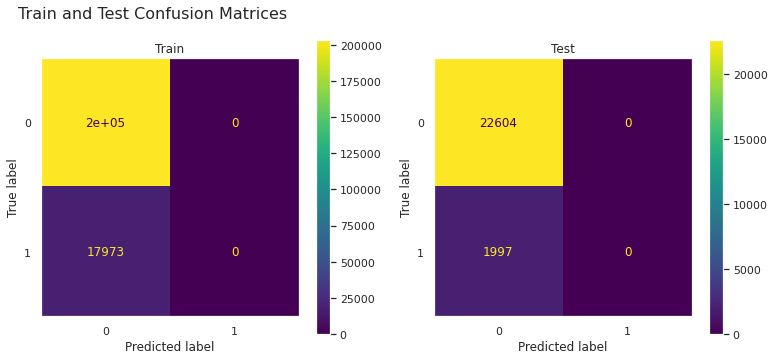

____________________________________________________________________________________________________


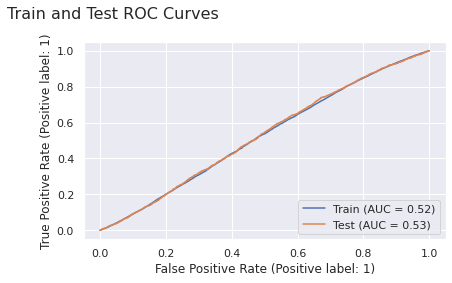

____________________________________________________________________________________________________

AUC-ROC Scores:
---------------
TRAIN: 0.5240
 TEST: 0.5269
____________________________________________________________________________________________________


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=None,
                                                    test_size=0.1, 
                                                    random_state=42, 
                                                    stratify=y)

lr = LogisticRegression().fit(X_train, y_train)

show_metrics_of(lr, X_train, X_test, y_train, y_test)

Vemos que o modelo está horrível. Ele prevê que todos serão bons pagadores.

Vamos incluir a idade para ver se algo melhora.

### Regressão Logística com 3 features

In [24]:
selected_columns.append('DAYS_BIRTH')
X = X_df[selected_columns]

____________________________________________________________________________________________________


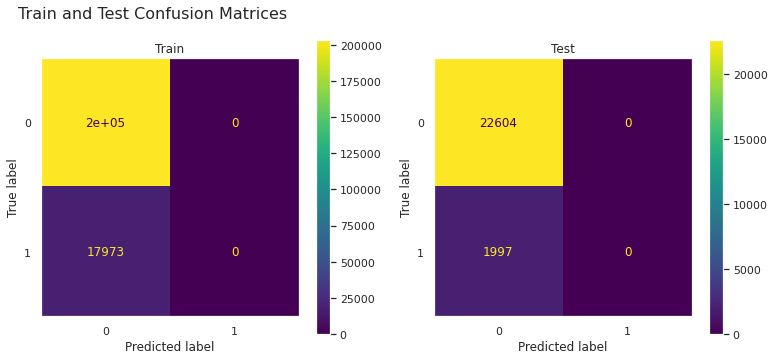

____________________________________________________________________________________________________


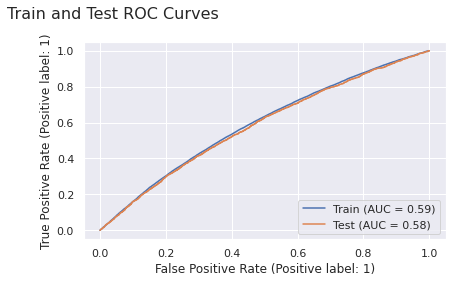

____________________________________________________________________________________________________

AUC-ROC Scores:
---------------
TRAIN: 0.5912
 TEST: 0.5824
____________________________________________________________________________________________________


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=None,
                                                    test_size=0.1, 
                                                    random_state=42, 
                                                    stratify=y)

lr = LogisticRegression().fit(X_train, y_train)

show_metrics_of(lr, X_train, X_test, y_train, y_test)

Continua classificando todos como da classe 0, mas o valor da métrica de avaliação sofreu um bom incremento.

Vamos incluir todas as features numéricas sem valores nulos.

## Considerando Features Numéricas com Registros Completos

Nessa seção, vamos treinar os modelos apenas com as features numéricas que não apresentem dados nulos.

Começaremos com a regressão logística, e vamos passando por outros métodos/estimadores. Em todos os casos, faremos uma modelagem simples com dado estimador para logo em seguida testarmos hiperparâmetros que resultem num modelo melhor.

In [12]:
selected_columns = X_df.select_dtypes(include=np.number).dropna(axis=1).columns
selected_columns

Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'],


In [13]:
X_df[selected_columns].shape

(246008, 43)

In [14]:
X = X_df[selected_columns]

### Regressão Logística

____________________________________________________________________________________________________


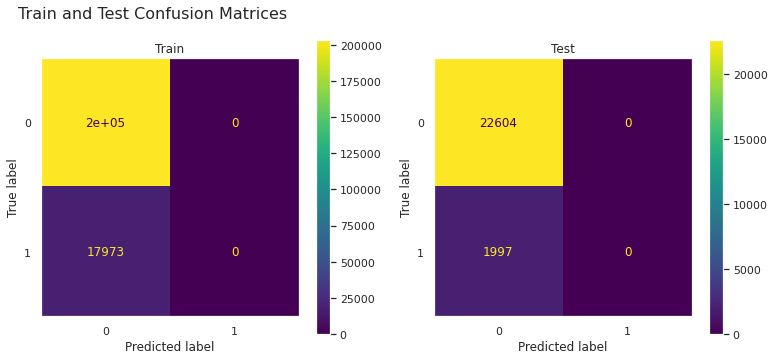

____________________________________________________________________________________________________


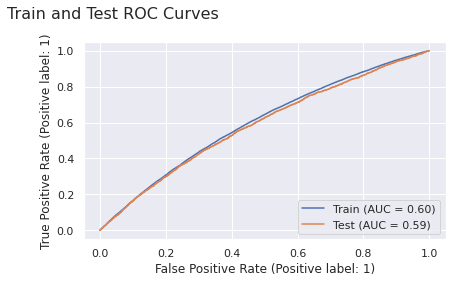

____________________________________________________________________________________________________

AUC-ROC Scores:
---------------
TRAIN: 0.5983
 TEST: 0.5858
____________________________________________________________________________________________________


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=None,
                                                    test_size=0.1, 
                                                    random_state=42, 
                                                    stratify=y)

lr = LogisticRegression().fit(X_train, y_train)

show_metrics_of(lr, X_train, X_test, y_train, y_test)

Mesmo com muito mais informação o desempenho não melhorou quase nada. 

Continua jogando todas as observações na classe de "bons pagadores".

#### Considerando o desbalanço: nosso modelo de referência inicial

Vamos mudar alguns parâmetros do estimador. 

Em especial vamos levar em consideração o desbalanço das classes.

____________________________________________________________________________________________________


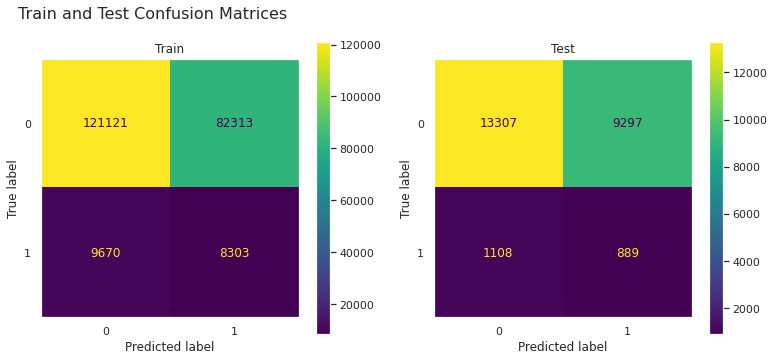

____________________________________________________________________________________________________


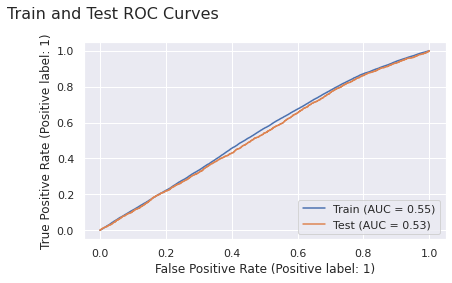

____________________________________________________________________________________________________

AUC-ROC Scores:
---------------
TRAIN: 0.5463
 TEST: 0.5338
____________________________________________________________________________________________________


In [30]:
lr = LogisticRegression(class_weight='balanced').fit(X_train, y_train)

show_metrics_of(lr, X_train, X_test, y_train, y_test)

Pronto! Parece que aprendeu algo novo, embora o valor da métrica tenha diminuído em relação ao último. 

Vamos tomar este modelo como referência inicial e salvá-lo.

In [31]:
from joblib import dump, load

dump(lr, './models/lr_num_feats_with_no_nulls.joblib') 

['./models/lr_num_feats_with_no_nulls.joblib']

#### Buscando melhores hiperparâmetros

Vamos agora testar com outros hiperparâmetros da regressão logística.

Além disso, a partir de agora vamos introduzir também a validação cruzada.

Vamos trabalhar com apenas uma parte dos dados por questão de eficiência.

____________________________________________________________________________________________________


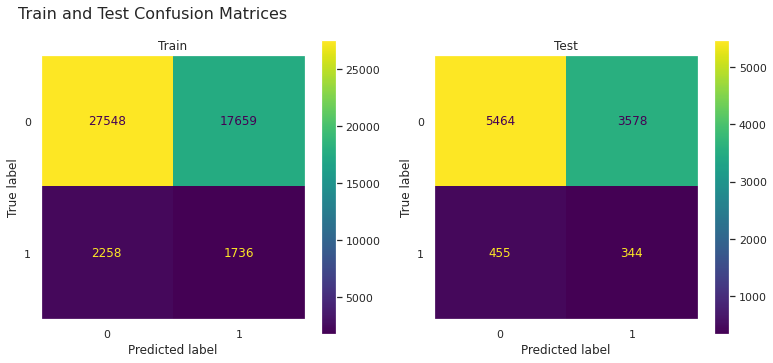

____________________________________________________________________________________________________


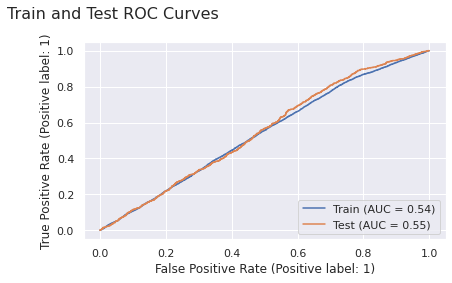

____________________________________________________________________________________________________

AUC-ROC Scores:
---------------
TRAIN: 0.5399
 TEST: 0.5495
____________________________________________________________________________________________________


In [32]:
# Aqui diminuimos o tamanho das amostras de treino e teste.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2,
                                                    test_size=0.04, 
                                                    random_state=42, 
                                                    stratify=y)

splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Escolhemos o solver 'saga' pois é o único que permite escolha de regularização 
# do tipo elasticnet e, portanto, podemos testar l1, l2 ou uma mescla de ambos.
lrCV = LogisticRegressionCV(Cs=np.linspace(0.1, 1.5, 5), 
                            scoring='roc_auc', 
                            solver='saga',
                            random_state=42,
                            cv=splitter,
                            class_weight='balanced', 
                            penalty='elasticnet', 
                            l1_ratios=np.linspace(0, 1, 5),
                            max_iter=300,
                            n_jobs=-1)

lrCV.fit(X_train, y_train)

show_metrics_of(lrCV, X_train, X_test, y_train, y_test)

Houve ligeira alteração nos *scores*. Porém fizemos a modelagem com um número menor dados.

Vejamos quais foram os melhores hiperparâmeros envolvidos.

In [33]:
lrCV.l1_ratio_

array([0.25])

In [34]:
lrCV.C_

array([1.5])

Vamos salvá-lo.

In [31]:
from joblib import dump

In [35]:
dump(lrCV, './models/lrCV_num_feats_with_no_nulls.joblib')

['./models/lrCV_num_feats_with_no_nulls.joblib']

___

### KNN

Vamos agora tentar a classificação com o KNN.

Precisaremos deixar os dados numa mesma escala. Para tanto vamos usar o *MinMaxScaler*.

Vamos alterar nossa função para comportar a parte de escalar os dados.

____________________________________________________________________________________________________


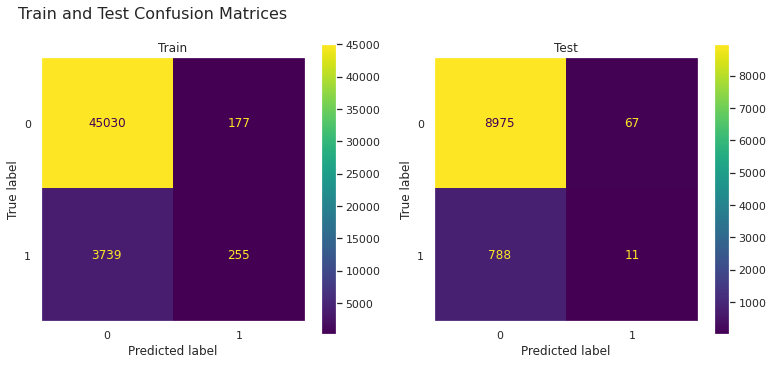

____________________________________________________________________________________________________


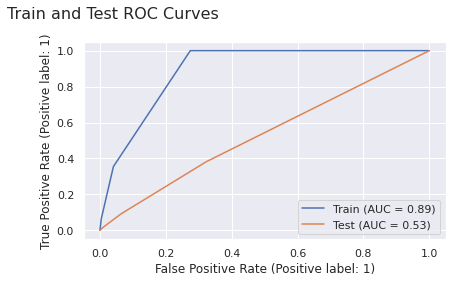

____________________________________________________________________________________________________

AUC-ROC Scores:
---------------
TRAIN: 0.8917
 TEST: 0.5322
____________________________________________________________________________________________________


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.2,
                                                    test_size=0.04, 
                                                    random_state=42, 
                                                    stratify=y)

#==================================================================

mms = MinMaxScaler().fit(X_train)

X_train_mms = mms.transform(X_train)
X_test_mms = mms.transform(X_test)

#==================================================================

knn = KNeighborsClassifier().fit(X_train_mms, y_train)

show_metrics_of(knn, X_train_mms, X_test_mms, y_train, y_test)

Vemos que o modelo está com *overfitting*. 

Vejamos se alterando um pouco os parêmtros há uma melhora. Aqui vamos usar *RandonSearch* com validação cruzada.

#### Buscando melhores hiperparâmetros

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.2,
                                                    test_size=0.05, 
                                                    random_state=42, 
                                                    stratify=y)

#==================================================================

mms = MinMaxScaler().fit(X_train)

X_train_mms = mms.transform(X_train)
X_test_mms = mms.transform(X_test)

#==================================================================

knn = KNeighborsClassifier(n_jobs=-1).fit(X_train_mms, y_train)

splitter = StratifiedKFold(shuffle=True, random_state=42)

params_grid_knn = {
    'n_neighbors' : range(3, 16, 2),
    'weights' : ["uniform", "distance"],
    'p' : [1, 2],
}

grid_knn = RandomizedSearchCV(estimator=knn, 
                              param_distributions=params_grid_knn,
                              n_iter=20,
                              scoring='roc_auc',
                              cv=splitter,
                              verbose=4)

grid_knn.fit(X_train_mms, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END n_neighbors=13, p=2, weights=distance;, score=0.570 total time=  10.5s
[CV 2/5] END n_neighbors=13, p=2, weights=distance;, score=0.570 total time=  10.1s
[CV 3/5] END n_neighbors=13, p=2, weights=distance;, score=0.556 total time=   9.5s
[CV 4/5] END n_neighbors=13, p=2, weights=distance;, score=0.594 total time=   9.6s
[CV 5/5] END n_neighbors=13, p=2, weights=distance;, score=0.556 total time=   9.7s
[CV 1/5] END n_neighbors=7, p=1, weights=distance;, score=0.544 total time=   9.9s
[CV 2/5] END n_neighbors=7, p=1, weights=distance;, score=0.543 total time=   9.8s
[CV 3/5] END n_neighbors=7, p=1, weights=distance;, score=0.545 total time=   9.1s
[CV 4/5] END n_neighbors=7, p=1, weights=distance;, score=0.562 total time=   9.1s
[CV 5/5] END n_neighbors=7, p=1, weights=distance;, score=0.542 total time=   9.1s
[CV 1/5] END n_neighbors=3, p=2, weights=uniform;, score=0.534 total time=   8.6s
[CV 2/5] END n_neighb

[CV 5/5] END n_neighbors=5, p=2, weights=uniform;, score=0.545 total time=   9.7s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=KNeighborsClassifier(n_jobs=-1), n_iter=20,
                   param_distributions={'n_neighbors': range(3, 16, 2),
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   scoring='roc_auc', verbose=4)

____________________________________________________________________________________________________


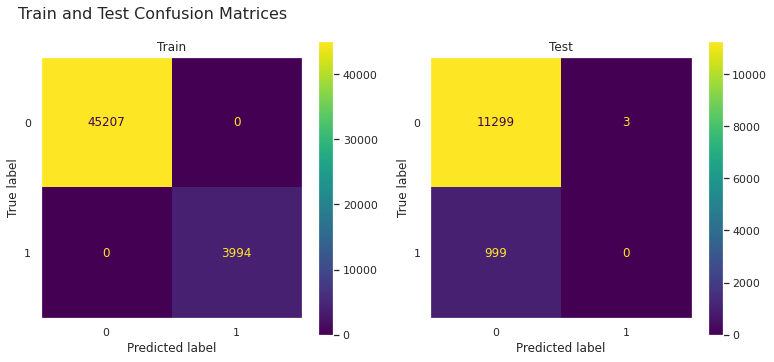

____________________________________________________________________________________________________


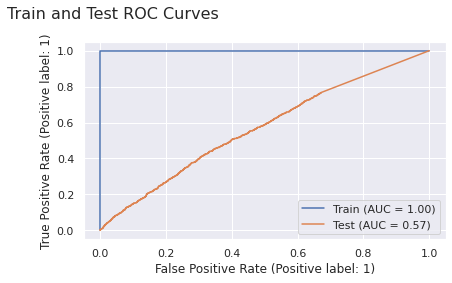

____________________________________________________________________________________________________

AUC-ROC Scores:
---------------
TRAIN: 1.0000
 TEST: 0.5677
____________________________________________________________________________________________________


In [28]:
show_metrics_of(grid_knn, X_train_mms, X_test_mms, y_train, y_test)

In [29]:
grid_knn.best_params_

{'weights': 'distance', 'p': 2, 'n_neighbors': 15}

Novamente, embora tenha melhorado a métrica, houve sobreajuste bem forte.

Dado que as classes muito desbalanceadas, é de se esperar que o KNN não tenha um bom desempenho uma vez que é bem provável que os vizinhos de cada ponto sejam em sua maioria da classe mais numerosa.

___

### Árvore de Decisão

Vamos agora tentar com uma árvore e vamos limitar a profundidade a 10, pois já sabemos que árvores de decisão, se não limitadas, tendem a sobreajustar o aprendizado.

____________________________________________________________________________________________________


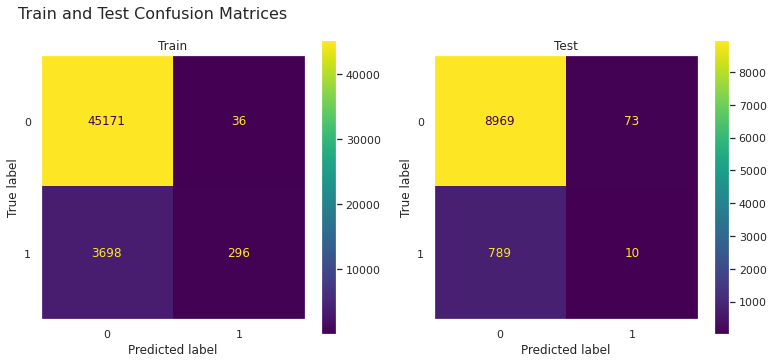

____________________________________________________________________________________________________


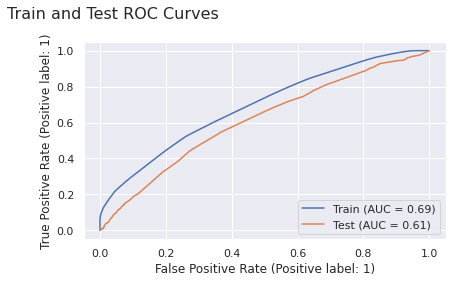

____________________________________________________________________________________________________

AUC-ROC Scores:
---------------
TRAIN: 0.6903
 TEST: 0.6122
____________________________________________________________________________________________________


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.2,
                                                    test_size=0.04, 
                                                    random_state=42, 
                                                    stratify=y)

#==================================================================

mms = MinMaxScaler().fit(X_train)

X_train_mms = mms.transform(X_train)
X_test_mms = mms.transform(X_test)

#==================================================================

dt = DecisionTreeClassifier(max_depth=10).fit(X_train_mms, y_train)

show_metrics_of(dt, X_train_mms, X_test_mms, y_train, y_test)

Melhorou bem a métrica de avaliação.

Vamos salvar o modelo.

In [34]:
from joblib import dump
dump(dt, './models/dt_num_features_with_no_nulls.joblib')

['./models/dt_num_features_with_no_nulls.joblib']

Vamos tentar com *class_weight='balanced'*

____________________________________________________________________________________________________


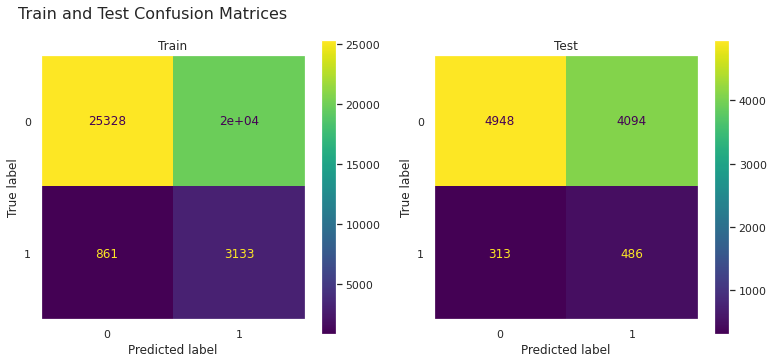

____________________________________________________________________________________________________


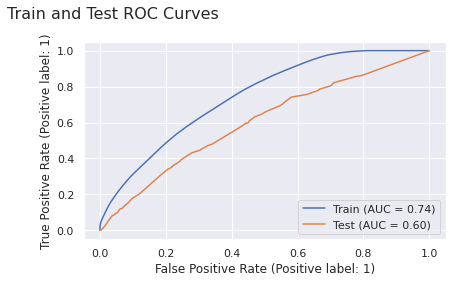

____________________________________________________________________________________________________

AUC-ROC Scores:
---------------
TRAIN: 0.7449
 TEST: 0.6017
____________________________________________________________________________________________________


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.2,
                                                    test_size=0.04, 
                                                    random_state=42, 
                                                    stratify=y)

#==================================================================

mms = MinMaxScaler().fit(X_train)

X_train_mms = mms.transform(X_train)
X_test_mms = mms.transform(X_test)

#==================================================================

dt = DecisionTreeClassifier(max_depth=10, class_weight='balanced').fit(X_train_mms, y_train)

show_metrics_of(dt, X_train_mms, X_test_mms, y_train, y_test)

Caminhamos um pouco para o lado de maior variância. Então parece que *class_weight='balanced'* não ajudou muito.

#### Buscando melhores hiperparâmetros

Agora vamos variar os hiperparâmetros da árvore.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.2,
                                                    test_size=0.04, 
                                                    random_state=42, 
                                                    stratify=y)

#==================================================================

mms = MinMaxScaler().fit(X_train)

X_train_mms = mms.transform(X_train)
X_test_mms = mms.transform(X_test)

#==================================================================

splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

dt = DecisionTreeClassifier(random_state=42)

params_grid_dt = {
    'criterion' : ["gini", "entropy"],
    'splitter' : ["best", "random"],
    'max_depth' : range(2, 18, 3), # [2, 5, 8, 11, 14, 17]
}

grid_dt = GridSearchCV(estimator=dt, 
                      param_grid=params_grid_dt, 
                      scoring='roc_auc', 
                      cv=splitter, 
                      verbose=5, 
                      n_jobs=-1)

grid_dt.fit(X_train_mms, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 18, 3),
                         'splitter': ['best', 'random']},
             scoring='roc_auc', verbose=5)

____________________________________________________________________________________________________


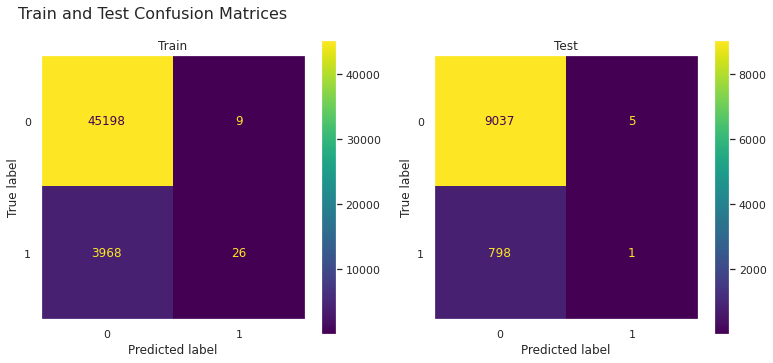

____________________________________________________________________________________________________


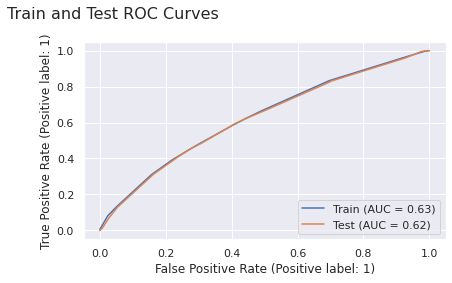

____________________________________________________________________________________________________

AUC-ROC Scores:
---------------
TRAIN: 0.6273
 TEST: 0.6222
____________________________________________________________________________________________________


In [41]:
show_metrics_of(grid_dt, X_train_mms, X_test_mms, y_train, y_test)

Melhorou mais um pouquinho. Vejamos os parâmetros escolhidos.

In [42]:
grid_dt.best_params_

{'criterion': 'gini', 'max_depth': 5, 'splitter': 'best'}

Vamos salvá-lo.

In [44]:
dump(grid_dt, './models/grid_dt_num_features_with_no_nulls.joblib')

['./models/grid_dt_num_features_with_no_nulls.joblib']

___

### RandomForest

Agora vamos tentar com o *RandomForest*

____________________________________________________________________________________________________


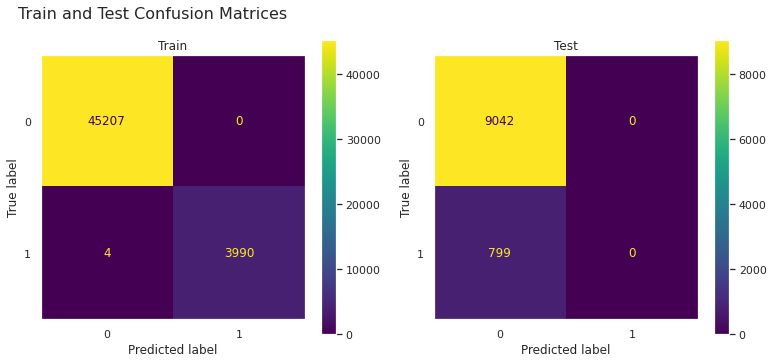

____________________________________________________________________________________________________


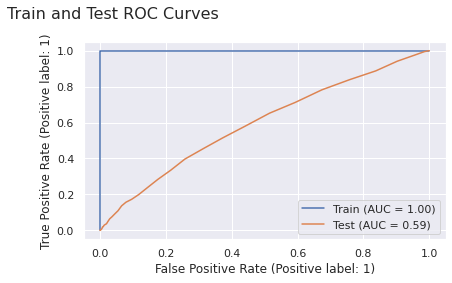

____________________________________________________________________________________________________

AUC-ROC Scores:
---------------
TRAIN: 1.0000
 TEST: 0.5949
____________________________________________________________________________________________________


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.2,
                                                    test_size=0.04, 
                                                    random_state=42, 
                                                    stratify=y)

#==================================================================

mms = MinMaxScaler().fit(X_train)

X_train_mms = mms.transform(X_train)
X_test_mms = mms.transform(X_test)

#==================================================================

rf = RandomForestClassifier(random_state=42, n_jobs=-1).fit(X_train_mms, y_train)

show_metrics_of(rf, X_train_mms, X_test_mms, y_train, y_test)

Claro *overfitting*. 

#### Buscando melhores hiperparâmetros
Vamos aplicar regularização buscando por melhores hiperparâmetros.

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.2,
                                                    test_size=0.04, 
                                                    random_state=42, 
                                                    stratify=y)

#==================================================================

mms = MinMaxScaler().fit(X_train)

X_train_mms = mms.transform(X_train)
X_test_mms = mms.transform(X_test)

#==================================================================

splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

params_grid_rf = {
    'n_estimators': range(100, 501),
    'criterion' : ["gini", "entropy"],
    'max_depth' : range(2, 11),
    'class_weight': ['balanced', 'balanced_subsample']
}

grid_rf = RandomizedSearchCV(estimator=rf, 
                             param_distributions=params_grid_rf, 
                             scoring='roc_auc', 
                             cv=splitter, 
                             n_iter=36,
                             verbose=5)

grid_rf.fit(X_train_mms, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END class_weight=balanced_subsample, criterion=entropy, max_depth=8, n_estimators=376;, score=0.642 total time=   4.6s
[CV 2/5] END class_weight=balanced_subsample, criterion=entropy, max_depth=8, n_estimators=376;, score=0.620 total time=   3.8s
[CV 3/5] END class_weight=balanced_subsample, criterion=entropy, max_depth=8, n_estimators=376;, score=0.620 total time=   3.7s
[CV 4/5] END class_weight=balanced_subsample, criterion=entropy, max_depth=8, n_estimators=376;, score=0.652 total time=   3.7s
[CV 5/5] END class_weight=balanced_subsample, criterion=entropy, max_depth=8, n_estimators=376;, score=0.631 total time=   3.6s
[CV 1/5] END class_weight=balanced_subsample, criterion=gini, max_depth=6, n_estimators=174;, score=0.640 total time=   1.6s
[CV 2/5] END class_weight=balanced_subsample, criterion=gini, max_depth=6, n_estimators=174;, score=0.621 total time=   1.5s
[CV 3/5] END class_weight=balanced_subsample, cr

[CV 1/5] END class_weight=balanced_subsample, criterion=gini, max_depth=5, n_estimators=485;, score=0.638 total time=   3.5s
[CV 2/5] END class_weight=balanced_subsample, criterion=gini, max_depth=5, n_estimators=485;, score=0.621 total time=   3.5s
[CV 3/5] END class_weight=balanced_subsample, criterion=gini, max_depth=5, n_estimators=485;, score=0.618 total time=   3.6s
[CV 4/5] END class_weight=balanced_subsample, criterion=gini, max_depth=5, n_estimators=485;, score=0.644 total time=   3.6s
[CV 5/5] END class_weight=balanced_subsample, criterion=gini, max_depth=5, n_estimators=485;, score=0.631 total time=   3.5s
[CV 1/5] END class_weight=balanced, criterion=entropy, max_depth=6, n_estimators=470;, score=0.642 total time=   3.3s
[CV 2/5] END class_weight=balanced, criterion=entropy, max_depth=6, n_estimators=470;, score=0.622 total time=   3.4s
[CV 3/5] END class_weight=balanced, criterion=entropy, max_depth=6, n_estimators=470;, score=0.620 total time=   3.4s
[CV 4/5] END class_we

[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=8, n_estimators=306;, score=0.631 total time=   2.5s
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=8, n_estimators=153;, score=0.643 total time=   1.4s
[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=8, n_estimators=153;, score=0.619 total time=   1.4s
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=8, n_estimators=153;, score=0.621 total time=   1.4s
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=8, n_estimators=153;, score=0.650 total time=   1.4s
[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=8, n_estimators=153;, score=0.633 total time=   1.4s
[CV 1/5] END class_weight=balanced, criterion=entropy, max_depth=2, n_estimators=498;, score=0.625 total time=   2.0s
[CV 2/5] END class_weight=balanced, criterion=entropy, max_depth=2, n_estimators=498;, score=0.616 total time=   2.0s
[CV 3/5] END class_weight=balanced, criterion=entropy, max_depth=2, n_esti

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=36,
                   param_distributions={'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': range(2, 11),
                                        'n_estimators': range(100, 501)},
                   scoring='roc_auc', verbose=5)

____________________________________________________________________________________________________


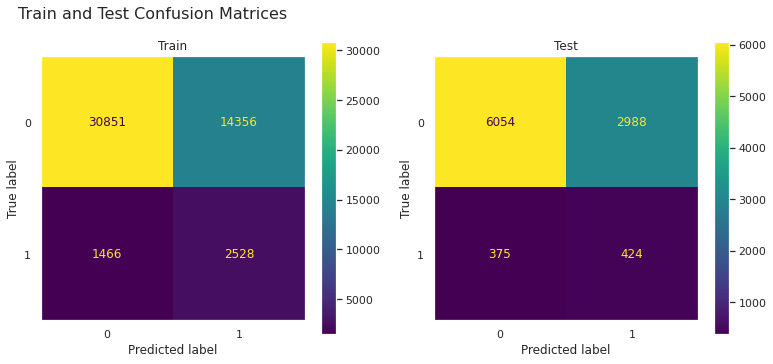

____________________________________________________________________________________________________


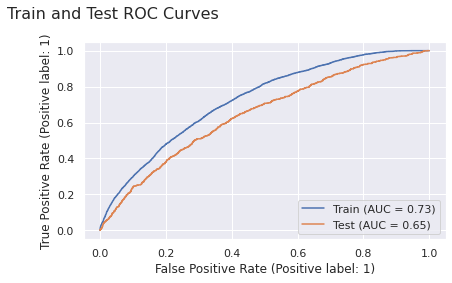

____________________________________________________________________________________________________

AUC-ROC Scores:
---------------
TRAIN: 0.7252
 TEST: 0.6463
____________________________________________________________________________________________________


In [53]:
show_metrics_of(grid_rf, X_train_mms, X_test_mms, y_train, y_test)

Conseguimos melhorar um pouco e sem *overfitting*.

Vamos dar uma olhada nos hiperparâmetros escolhidos.

In [54]:
grid_rf.best_params_

{'n_estimators': 306,
 'max_depth': 8,
 'criterion': 'gini',
 'class_weight': 'balanced'}

#### Refinando a busca por hiperparâmetros

Vamos tentar novamente, mas agora limitando a distribuição dos valores em torno dos melhores hiperparâmetros escolhidos acima.

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.2,
                                                    test_size=0.04, 
                                                    random_state=42, 
                                                    stratify=y)

#==================================================================

mms = MinMaxScaler().fit(X_train)

X_train_mms = mms.transform(X_train)
X_test_mms = mms.transform(X_test)

#==================================================================

splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

params_grid_rf = {
    'n_estimators': range(250, 501),
    'criterion' : ["gini", "entropy"],
    'max_depth' : range(5, 12),
    'class_weight': ['balanced', 'balanced_subsample']
}

grid_rf = RandomizedSearchCV(estimator=rf, 
                             param_distributions=params_grid_rf, 
                             scoring='roc_auc', 
                             cv=splitter, 
                             n_iter=30,
                             verbose=4)

grid_rf.fit(X_train_mms, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END class_weight=balanced_subsample, criterion=entropy, max_depth=9, n_estimators=358;, score=0.642 total time=   4.6s
[CV 2/5] END class_weight=balanced_subsample, criterion=entropy, max_depth=9, n_estimators=358;, score=0.618 total time=   4.0s
[CV 3/5] END class_weight=balanced_subsample, criterion=entropy, max_depth=9, n_estimators=358;, score=0.620 total time=   3.7s
[CV 4/5] END class_weight=balanced_subsample, criterion=entropy, max_depth=9, n_estimators=358;, score=0.654 total time=   3.7s
[CV 5/5] END class_weight=balanced_subsample, criterion=entropy, max_depth=9, n_estimators=358;, score=0.632 total time=   3.7s
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=5, n_estimators=291;, score=0.638 total time=   1.9s
[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=5, n_estimators=291;, score=0.621 total time=   1.9s
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=5, n_e

[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=8, n_estimators=307;, score=0.622 total time=   2.5s
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=8, n_estimators=307;, score=0.654 total time=   2.5s
[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=8, n_estimators=307;, score=0.631 total time=   2.5s
[CV 1/5] END class_weight=balanced_subsample, criterion=gini, max_depth=10, n_estimators=494;, score=0.640 total time=   4.9s
[CV 2/5] END class_weight=balanced_subsample, criterion=gini, max_depth=10, n_estimators=494;, score=0.617 total time=   5.0s
[CV 3/5] END class_weight=balanced_subsample, criterion=gini, max_depth=10, n_estimators=494;, score=0.619 total time=   4.8s
[CV 4/5] END class_weight=balanced_subsample, criterion=gini, max_depth=10, n_estimators=494;, score=0.654 total time=   5.1s
[CV 5/5] END class_weight=balanced_subsample, criterion=gini, max_depth=10, n_estimators=494;, score=0.630 total time=   5.0s
[CV 1/5] END class_weight

[CV 1/5] END class_weight=balanced, criterion=entropy, max_depth=6, n_estimators=395;, score=0.642 total time=   2.9s
[CV 2/5] END class_weight=balanced, criterion=entropy, max_depth=6, n_estimators=395;, score=0.622 total time=   2.8s
[CV 3/5] END class_weight=balanced, criterion=entropy, max_depth=6, n_estimators=395;, score=0.619 total time=   2.8s
[CV 4/5] END class_weight=balanced, criterion=entropy, max_depth=6, n_estimators=395;, score=0.648 total time=   2.9s
[CV 5/5] END class_weight=balanced, criterion=entropy, max_depth=6, n_estimators=395;, score=0.632 total time=   2.8s
[CV 1/5] END class_weight=balanced, criterion=entropy, max_depth=10, n_estimators=370;, score=0.640 total time=   3.5s
[CV 2/5] END class_weight=balanced, criterion=entropy, max_depth=10, n_estimators=370;, score=0.616 total time=   3.6s
[CV 3/5] END class_weight=balanced, criterion=entropy, max_depth=10, n_estimators=370;, score=0.621 total time=   3.5s
[CV 4/5] END class_weight=balanced, criterion=entropy

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=30,
                   param_distributions={'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': range(5, 12),
                                        'n_estimators': range(250, 501)},
                   scoring='roc_auc', verbose=4)

____________________________________________________________________________________________________


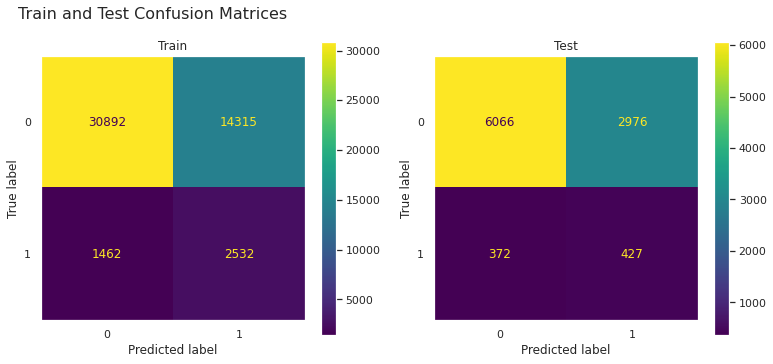

____________________________________________________________________________________________________


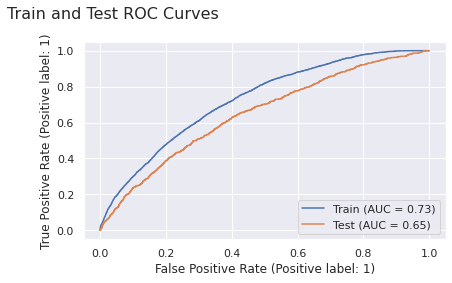

____________________________________________________________________________________________________

AUC-ROC Scores:
---------------
TRAIN: 0.7257
 TEST: 0.6477
____________________________________________________________________________________________________


In [56]:
show_metrics_of(grid_rf, X_train_mms, X_test_mms, y_train, y_test)

In [57]:
grid_rf.best_params_

{'n_estimators': 476,
 'max_depth': 8,
 'criterion': 'gini',
 'class_weight': 'balanced'}

Exceto pelo número de árvores, os hiperparâmetros escolhidos foram os mesmos com praticamente a mesma pontuação.

Guardemos o modelo.

In [58]:
dump(grid_rf, './models/grid_rf_num_features_with_no_nulls.joblib')

['./models/grid_rf_num_features_with_no_nulls.joblib']

___

### *Adaptative Boosting*

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.2,
                                                    test_size=0.04, 
                                                    random_state=42, 
                                                    stratify=y)

#==================================================================

mms = MinMaxScaler().fit(X_train)

X_train_mms = mms.transform(X_train)
X_test_mms = mms.transform(X_test)

#==================================================================

ab = AdaBoostClassifier(random_state=42)

ab.fit(X_train_mms, y_train)

AdaBoostClassifier(random_state=42)

____________________________________________________________________________________________________


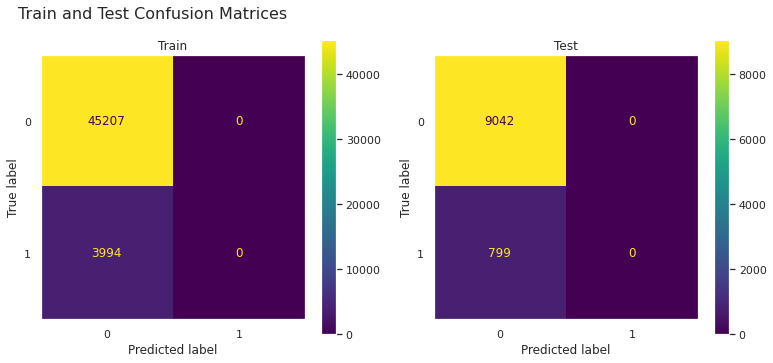

____________________________________________________________________________________________________


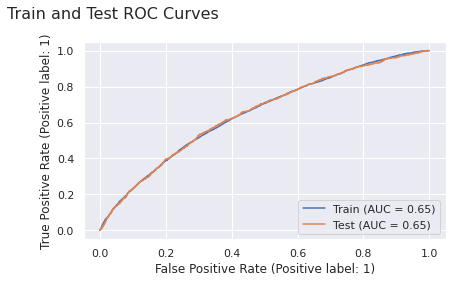

____________________________________________________________________________________________________

AUC-ROC Scores:
---------------
TRAIN: 0.6518
 TEST: 0.6514
____________________________________________________________________________________________________


In [61]:
show_metrics_of(ab, X_train_mms, X_test_mms, y_train, y_test)

In [62]:
ab.n_estimators

50

Melhorou em mais um décimo a pontuação, mas na matriz de confusão está classificando todos como 0.

In [63]:
dump(ab, './models/ab_num_features_with_no_nulls.joblib')

['./models/ab_num_features_with_no_nulls.joblib']

### *Gradient Boosting*

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.2,
                                                    test_size=0.04, 
                                                    random_state=42, 
                                                    stratify=y)

#==================================================================

mms = MinMaxScaler().fit(X_train)

X_train_mms = mms.transform(X_train)
X_test_mms = mms.transform(X_test)

#==================================================================

gb = GradientBoostingClassifier(random_state=42).fit(X_train_mms, y_train)

____________________________________________________________________________________________________


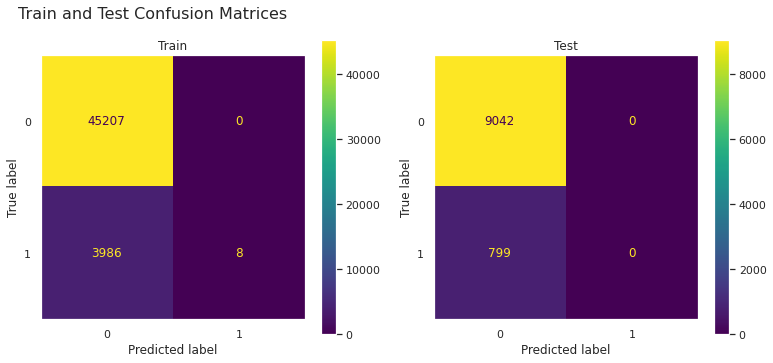

____________________________________________________________________________________________________


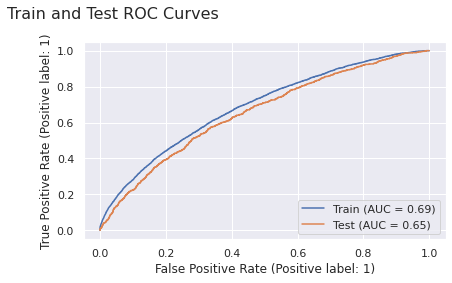

____________________________________________________________________________________________________

AUC-ROC Scores:
---------------
TRAIN: 0.6873
 TEST: 0.6544
____________________________________________________________________________________________________


In [70]:
show_metrics_of(gb, X_train_mms, X_test_mms, y_train, y_test)

Melhorou um pouco em relação à pontuação *auc_roc* comparado ao *AdaBoosting*. E continua classificando todos como da classe 0.

In [73]:
dump(gb, './models/gb_num_features_with_no_nulls.joblib')

['./models/gb_num_features_with_no_nulls.joblib']

#### Buscando melhores hiperparâmetros

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.2,
                                                    test_size=0.04, 
                                                    random_state=42, 
                                                    stratify=y)

#==================================================================

mms = MinMaxScaler().fit(X_train)

X_train_mms = mms.transform(X_train)
X_test_mms = mms.transform(X_test)

#==================================================================

splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gb = GradientBoostingClassifier(random_state=42)

params_grid_gb = {
    'n_estimators': range(200, 601),
    'learning_rate': np.linspace(0.01, 0.1, 5),
    'criterion' : ['friedman_mse', 'squared_error'],
    'max_depth' : range(1, 4)
}

grid_gb = RandomizedSearchCV(estimator=gb, 
                             param_distributions=params_grid_gb, 
                             scoring='roc_auc', 
                             cv=splitter, 
                             n_iter=20,
                             n_jobs=-1,
                             verbose=2)

grid_gb.fit(X_train_mms, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'criterion': ['friedman_mse',
                                                      'squared_error'],
                                        'learning_rate': array([0.01  , 0.0325, 0.055 , 0.0775, 0.1   ]),
                                        'max_depth': range(1, 4),
                                        'n_estimators': range(200, 601)},
                   scoring='roc_auc', verbose=2)

[CV] END criterion=friedman_mse, learning_rate=0.0775, max_depth=1, n_estimators=556; total time=  51.0s
[CV] END criterion=squared_error, learning_rate=0.05500000000000001, max_depth=2, n_estimators=517; total time= 1.5min
[CV] END criterion=squared_error, learning_rate=0.0325, max_depth=1, n_estimators=483; total time=  43.9s
[CV] END criterion=squared_error, learning_rate=0.1, max_depth=1, n_estimators=591; total time=  52.6s
[CV] END criterion=squared_error, learning_rate=0.0775, max_depth=3, n_estimators=318; total time= 1.3min
[CV] END criterion=friedman_mse, learning_rate=0.0325, max_depth=2, n_estimators=325; total time=  55.6s
[CV] END criterion=friedman_mse, learning_rate=0.0325, max_depth=1, n_estimators=386; total time=  36.2s
[CV] END criterion=friedman_mse, learning_rate=0.0325, max_depth=1, n_estimators=386; total time=  35.7s
[CV] END criterion=squared_error, learning_rate=0.1, max_depth=3, n_estimators=272; total time= 1.2min
[CV] END criterion=squared_error, learning_

[CV] END criterion=squared_error, learning_rate=0.0775, max_depth=1, n_estimators=330; total time=  32.6s
[CV] END criterion=squared_error, learning_rate=0.05500000000000001, max_depth=2, n_estimators=517; total time= 1.5min
[CV] END criterion=squared_error, learning_rate=0.05500000000000001, max_depth=2, n_estimators=551; total time= 1.6min
[CV] END criterion=squared_error, learning_rate=0.0775, max_depth=2, n_estimators=435; total time= 1.3min
[CV] END criterion=friedman_mse, learning_rate=0.0325, max_depth=2, n_estimators=325; total time=  53.6s
[CV] END criterion=friedman_mse, learning_rate=0.1, max_depth=3, n_estimators=590; total time= 2.4min
[CV] END criterion=squared_error, learning_rate=0.1, max_depth=2, n_estimators=364; total time= 1.0min
[CV] END criterion=squared_error, learning_rate=0.05500000000000001, max_depth=3, n_estimators=386; total time= 1.6min
[CV] END criterion=squared_error, learning_rate=0.0325, max_depth=2, n_estimators=427; total time= 1.2min
[CV] END criter

In [34]:
grid_gb.best_params_

{'n_estimators': 517,
 'max_depth': 2,
 'learning_rate': 0.05500000000000001,
 'criterion': 'squared_error'}

____________________________________________________________________________________________________


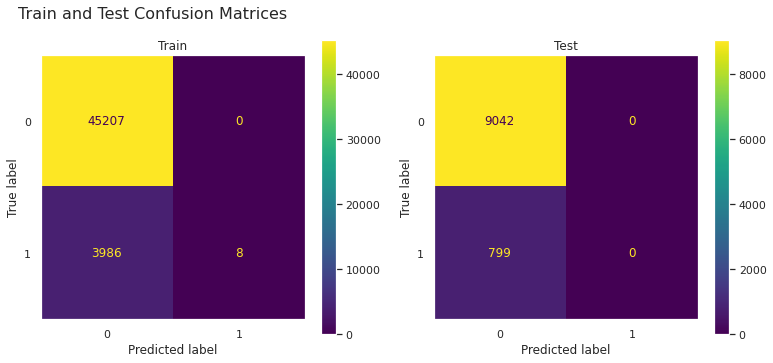

____________________________________________________________________________________________________


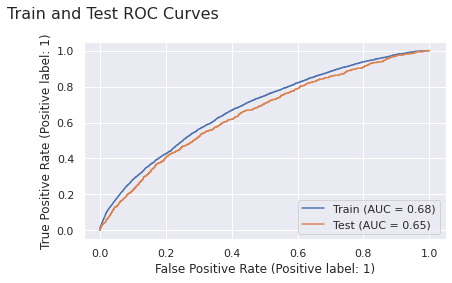

____________________________________________________________________________________________________

AUC-ROC Scores:
---------------
TRAIN: 0.6849
 TEST: 0.6530
____________________________________________________________________________________________________


In [35]:
show_metrics_of(grid_gb, X_train_mms, X_test_mms, y_train, y_test)

Praticamente não alterou a métrica.

In [22]:
from joblib import dump

dump(grid_gb, './models/grid_gb_num_features_with_no_nulls.joblib')

['./models/grid_gb_num_features_with_no_nulls.joblib']

___

### XGBossting

____________________________________________________________________________________________________


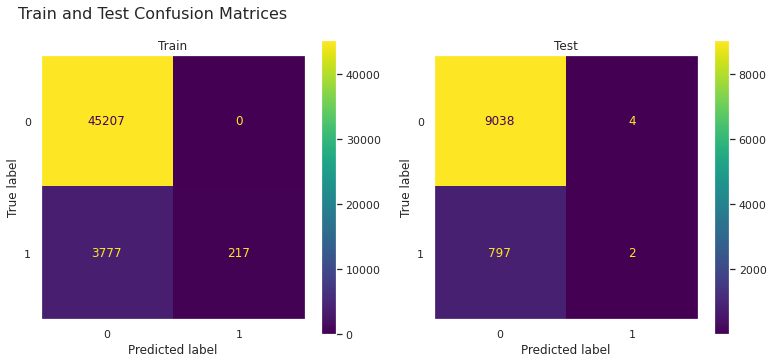

____________________________________________________________________________________________________


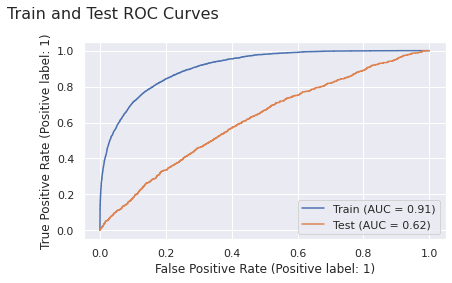

____________________________________________________________________________________________________

AUC-ROC Scores:
---------------
TRAIN: 0.9094
 TEST: 0.6158
____________________________________________________________________________________________________


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.2,
                                                    test_size=0.04, 
                                                    random_state=42, 
                                                    stratify=y)

#==================================================================

mms = MinMaxScaler().fit(X_train)

X_train_mms = mms.transform(X_train)
X_test_mms = mms.transform(X_test)

#==================================================================

xgb = XGBClassifier(eval_metric='logloss', random_state=42).fit(X_train_mms, y_train)

show_metrics_of(xgb, X_train_mms, X_test_mms, y_train, y_test)

A métrica de treino diminuiu em relação ao *Gradient Boosting*. Ao mesmo tempo, a métrica de treino aumentou bastante. Ou seja, o modelo está com alta variância.

#### Buscando melhores hiperparâmetros

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.2,
                                                    test_size=0.04, 
                                                    random_state=42, 
                                                    stratify=y)

#==================================================================

mms = MinMaxScaler().fit(X_train)

X_train_mms = mms.transform(X_train)
X_test_mms = mms.transform(X_test)

#==================================================================

splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb = XGBClassifier(eval_metric='logloss', random_state=42)

params_grid_xgb = {
    'n_estimators': range(100, 601),
    'learning_rate': np.linspace(0.1, 1, 10),
    'reg_alpha' : range(0, 21, 2),
    'max_depth' : range(1, 5)
}

grid_xgb = RandomizedSearchCV(estimator=xgb, 
                             param_distributions=params_grid_xgb, 
                             scoring='roc_auc', 
                             cv=splitter, 
                             n_iter=20,
                             n_jobs=-1,
                             verbose=2)

grid_xgb.fit(X_train_mms, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False,
                                           eval_metric='logloss', gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_st...
                                           predictor=None, random_state=42,
                                           reg_alpha=None, reg_lambda=None,
                                           scale_pos_weight=None,
       

In [29]:
grid_xgb.best_params_

{'reg_alpha': 8, 'n_estimators': 187, 'max_depth': 2, 'learning_rate': 0.6}

____________________________________________________________________________________________________


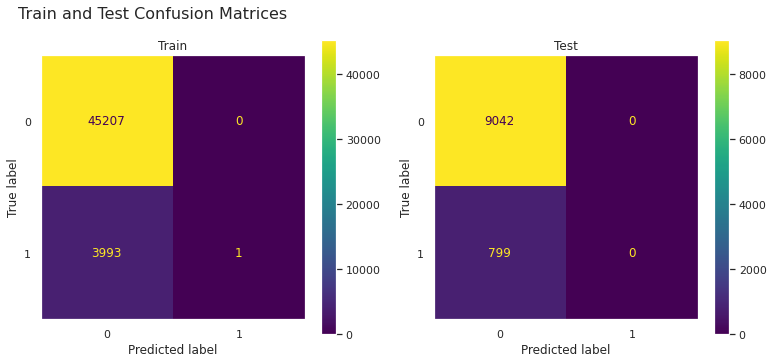

____________________________________________________________________________________________________


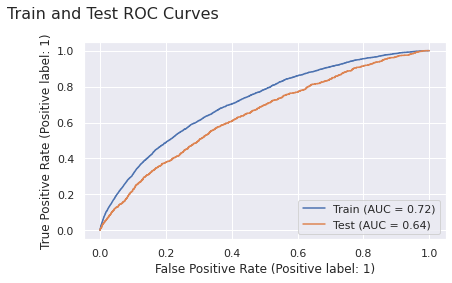

____________________________________________________________________________________________________

AUC-ROC Scores:
---------------
TRAIN: 0.7163
 TEST: 0.6438
____________________________________________________________________________________________________


/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarni

[CV] END learning_rate=0.8, max_depth=1, n_estimators=327, reg_alpha=12; total time= 3.0min
[CV] END learning_rate=0.30000000000000004, max_depth=2, n_estimators=429, reg_alpha=0; total time= 6.2min
[CV] END learning_rate=0.30000000000000004, max_depth=4, n_estimators=529, reg_alpha=14; total time= 6.2min
[CV] END learning_rate=0.9, max_depth=1, n_estimators=314, reg_alpha=4; total time= 2.5min
[CV] END learning_rate=0.9, max_depth=1, n_estimators=314, reg_alpha=4; total time= 2.4min
[CV] END learning_rate=0.4, max_depth=4, n_estimators=481, reg_alpha=14; total time= 5.7min
[CV] END learning_rate=0.7000000000000001, max_depth=3, n_estimators=190, reg_alpha=0; total time= 3.8min
[CV] END learning_rate=0.7000000000000001, max_depth=2, n_estimators=554, reg_alpha=14; total time= 4.7min
[CV] END learning_rate=1.0, max_depth=2, n_estimators=209, reg_alpha=8; total time= 3.0min
[CV] END learning_rate=1.0, max_depth=2, n_estimators=209, reg_alpha=8; total time= 2.8min
[CV] END learning_rate=0

/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarni

[CV] END learning_rate=0.8, max_depth=1, n_estimators=327, reg_alpha=12; total time= 3.0min
[CV] END learning_rate=0.7000000000000001, max_depth=2, n_estimators=210, reg_alpha=2; total time= 3.3min
[CV] END learning_rate=0.6, max_depth=2, n_estimators=187, reg_alpha=8; total time= 2.5min
[CV] END learning_rate=0.30000000000000004, max_depth=4, n_estimators=529, reg_alpha=14; total time= 6.4min
[CV] END learning_rate=0.6, max_depth=4, n_estimators=551, reg_alpha=2; total time=16.1min
[CV] END learning_rate=0.2, max_depth=1, n_estimators=155, reg_alpha=0; total time= 1.3min
[CV] END learning_rate=0.2, max_depth=1, n_estimators=155, reg_alpha=0; total time= 1.3min
[CV] END learning_rate=0.6, max_depth=3, n_estimators=538, reg_alpha=20; total time= 4.7min
[CV] END learning_rate=0.7000000000000001, max_depth=2, n_estimators=156, reg_alpha=2; total time= 2.1min
[CV] END learning_rate=1.0, max_depth=2, n_estimators=303, reg_alpha=16; total time= 2.7min
[CV] END learning_rate=0.300000000000000

In [31]:
show_metrics_of(grid_xgb, X_train_mms, X_test_mms, y_train, y_test)

Não melhorou a métrica de teste, mas saiu da região de alta variância, ou seja, o moldelo não está com sobreajuste.

In [32]:
dump(grid_gb, './models/grid_gb_num_features_with_no_nulls.joblib')

['./models/grid_gb_num_features_with_no_nulls.joblib']

[CV] END learning_rate=0.8, max_depth=1, n_estimators=327, reg_alpha=12; total time= 3.0min
[CV] END learning_rate=0.7000000000000001, max_depth=2, n_estimators=210, reg_alpha=2; total time= 3.3min
[CV] END learning_rate=0.6, max_depth=2, n_estimators=187, reg_alpha=8; total time= 2.5min
[CV] END learning_rate=0.30000000000000004, max_depth=4, n_estimators=529, reg_alpha=14; total time= 6.0min
[CV] END learning_rate=0.6, max_depth=4, n_estimators=551, reg_alpha=2; total time=16.1min
[CV] END learning_rate=0.7000000000000001, max_depth=2, n_estimators=554, reg_alpha=14; total time= 4.8min
[CV] END learning_rate=1.0, max_depth=2, n_estimators=209, reg_alpha=8; total time= 2.9min
[CV] END learning_rate=0.7000000000000001, max_depth=2, n_estimators=156, reg_alpha=2; total time= 2.0min
[CV] END learning_rate=0.7000000000000001, max_depth=1, n_estimators=200, reg_alpha=8; total time= 1.6min
[CV] END learning_rate=0.30000000000000004, max_depth=4, n_estimators=285, reg_alpha=16; total time= 3

/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarni

[CV] END learning_rate=0.8, max_depth=1, n_estimators=327, reg_alpha=12; total time= 3.1min
[CV] END learning_rate=0.30000000000000004, max_depth=2, n_estimators=429, reg_alpha=0; total time= 6.2min
[CV] END learning_rate=0.30000000000000004, max_depth=4, n_estimators=529, reg_alpha=14; total time= 6.0min
[CV] END learning_rate=0.9, max_depth=1, n_estimators=314, reg_alpha=4; total time= 2.5min
[CV] END learning_rate=0.9, max_depth=1, n_estimators=314, reg_alpha=4; total time= 2.4min
[CV] END learning_rate=0.4, max_depth=4, n_estimators=481, reg_alpha=14; total time= 5.4min
[CV] END learning_rate=0.4, max_depth=4, n_estimators=481, reg_alpha=14; total time= 5.6min
[CV] END learning_rate=0.7000000000000001, max_depth=2, n_estimators=554, reg_alpha=14; total time= 5.0min
[CV] END learning_rate=1.0, max_depth=2, n_estimators=209, reg_alpha=8; total time= 2.9min
[CV] END learning_rate=0.7000000000000001, max_depth=1, n_estimators=200, reg_alpha=8; total time= 1.5min
[CV] END learning_rate=

/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarni

[CV] END learning_rate=0.7000000000000001, max_depth=2, n_estimators=210, reg_alpha=2; total time= 3.3min
[CV] END learning_rate=0.6, max_depth=2, n_estimators=187, reg_alpha=8; total time= 2.9min
[CV] END learning_rate=0.6, max_depth=2, n_estimators=187, reg_alpha=8; total time= 2.5min
[CV] END learning_rate=0.6, max_depth=2, n_estimators=187, reg_alpha=8; total time= 2.5min
[CV] END learning_rate=0.6, max_depth=4, n_estimators=551, reg_alpha=2; total time=16.4min
[CV] END learning_rate=0.7000000000000001, max_depth=3, n_estimators=190, reg_alpha=0; total time= 3.7min
[CV] END learning_rate=0.2, max_depth=1, n_estimators=155, reg_alpha=0; total time= 1.3min
[CV] END learning_rate=0.2, max_depth=1, n_estimators=155, reg_alpha=0; total time= 1.3min
[CV] END learning_rate=0.6, max_depth=3, n_estimators=538, reg_alpha=20; total time= 4.6min
[CV] END learning_rate=0.7000000000000001, max_depth=2, n_estimators=156, reg_alpha=2; total time= 2.1min
[CV] END learning_rate=0.7000000000000001, m

/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarni

[CV] END learning_rate=0.7000000000000001, max_depth=2, n_estimators=210, reg_alpha=2; total time= 3.3min
[CV] END learning_rate=0.30000000000000004, max_depth=2, n_estimators=429, reg_alpha=0; total time= 6.2min
[CV] END learning_rate=0.6, max_depth=4, n_estimators=551, reg_alpha=2; total time=16.3min
[CV] END learning_rate=0.7000000000000001, max_depth=3, n_estimators=190, reg_alpha=0; total time= 3.8min
[CV] END learning_rate=0.7000000000000001, max_depth=2, n_estimators=554, reg_alpha=14; total time= 4.6min
[CV] END learning_rate=0.6, max_depth=3, n_estimators=538, reg_alpha=20; total time= 4.6min
[CV] END learning_rate=0.7000000000000001, max_depth=2, n_estimators=156, reg_alpha=2; total time= 2.1min
[CV] END learning_rate=1.0, max_depth=2, n_estimators=303, reg_alpha=16; total time= 2.8min
[CV] END learning_rate=0.5, max_depth=2, n_estimators=358, reg_alpha=4; total time= 4.7min
[CV] END learning_rate=0.4, max_depth=1, n_estimators=485, reg_alpha=14; total time= 3.5min


### Considerações Parciais

Nesta seção estivesmos modelando o problema com diversos estimadores considerando apenas as variáveis numéricas da base de dados. Não todas as numéricas: somente aquelas que não apresentavam nenhum dado faltante.

Para cada estimador, modelos o problema com as configurações padrão do estimador e em seguida aplicamos uma busca por paramêtros que levassem a uma melhor resposta.

Começamos com a regressão logística. A métrica de teste ficou em torno de 0.58, mas olhando para a matriz de confusão, ele classificava todos como senda da classe 0.

Passamos pelo KNN e por árvore de decisão, até chegarmos ao RandomForest, que teve o melhor desempenho olhando em conjunto, a métrica em si e a matriz de confusão. No caso alcançamos uma métrica em torno de 0.64 e sem classificar todos, quase todos como "0".

A partir daí partimos para os métodos de boosting: adapatative, gradient e extreme gradient. O máximo que conseguimos foi um aumento de 0.01 na métrica, mas com classificação praticamente constante em "0".

Ou seja, percebemos que chegamos a um limite. Mesmo variando os estimadores, a performance não se alterava. 

Sendo assim, em vez de testarmos outros métodos, como os bayesianos, por exemplo, vamos incluir mais variáveis dos dados originais.

## Modelagem Completa (*com Pipeline, com tudo...*)

Como dissemos acima, a ideia agora é incluir outras variáveis dos dados originais.

Para isso vamos utilizar *imputers*, *enconders* e *transformers*.

Além disso, vamos fazer o tratamento dessas *features* e outros passos do processo de modo mais estruturado por meio da "*Pipeline*".

Lembrando que em nossos modelos não estamos considerando a variável "Sexo" (*CODE_GENDER*) para não introduzir viés de gênero.

Além disso, da nossa análise exploratória, vimos que mais de 90% dos dados nulos eram provenientes das variáveis sobre média, mediana e moda de características das moradias dos solicitantes de crédito. Portanto, visando o custo computacional decidimos num priimeiro momento não incluir tais variáveis dado que todas elas apresentam mais de 47% de dados faltantes, algumas com esse porcentual chegando a quase 70%.

In [13]:
cols_to_drop = [col for col in X_df.columns if col.split('_')[-1] in ['AVG', 'MODE', 'MEDI']]

X = X_df.drop(columns=cols_to_drop)

### Criação das Pipelines de Pré-processamento

#### Features Numéricas Binárias

A todas as features numéricas binárias, ou seja, que indicam condição/estado binário, vamos usar a estratégia de preencher os dados faltantes com valor constante igual a -1 para destacar que desconhecemos o estado daquela observação.

E como garantia, vamos deixar os valores numa escala de -1 a 1, inclusos.

In [14]:
pipe_num_features_const = Pipeline([('inputer', SimpleImputer(strategy='constant', fill_value=-1)), 
                                    ('scaler', MinMaxScaler(feature_range=(-1, 1), clip=True))])

In [15]:
flags = [col for col in X.select_dtypes(include=np.number).columns if 'FLAG' in col]

nots = [col for col in X.select_dtypes(include=np.number).columns if 'NOT' in col]

ratings = [col for col in X.select_dtypes(include=np.number).columns if 'RATING' in col]

num_features_const =  flags + nots + ratings
num_features_const

['FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY']

#### Features Numéricas Contínuas

Para as variáveis contínuas vamos inserir a média nos dados nulos. Mesmo que haja outliers em algumas delas, como vamos trabalhar com cerca de 50 mil observações acreditamos que a média não será "muito" afetada por estes valores.

Nesse caso vamos escalar para valores entre 0 e 1.

In [16]:
pipe_num_features_mean = Pipeline([('inputer', SimpleImputer(strategy='mean')), 
                                   ('scaler', MinMaxScaler(clip=True))])

In [17]:
amts = [col for col in X.select_dtypes(include=np.number).columns if 'AMT' in col and 'REQ' not in col]

days = [col for col in X.select_dtypes(include=np.number).columns if 'DAYS' in col]

ext = [col for col in X.select_dtypes(include=np.number).columns if 'EXT' in col]

others = ['REGION_POPULATION_RELATIVE', 'OWN_CAR_AGE']

num_features_mean = amts + days + ext + others

num_features_mean

['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'REGION_POPULATION_RELATIVE',
 'OWN_CAR_AGE']

#### Features Numéricas Discretas não Binárias

Para as demais features numéricas, ou seja, as discretas não binárias mas com "poucos" níveis, vamos preencher os valores nulos com a mediana das observações e escalá-las para o intervalo [0, 1].

In [18]:
pipe_num_features_median = Pipeline([('inputer', SimpleImputer(strategy='median')), 
                                     ('scaler', MinMaxScaler(clip=True))])

In [19]:
soc_circle = [col for col in X.select_dtypes(include=np.number).columns if 'SOCIAL_CIRCLE' in col]

reqs = [col for col in X.select_dtypes(include=np.number).columns if 'REQ' in col]

fam_members = ['CNT_CHILDREN', 'CNT_FAM_MEMBERS']

num_features_median = soc_circle + reqs + fam_members

num_features_median

['OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'CNT_CHILDREN',
 'CNT_FAM_MEMBERS']

#### Features Categóricas

Para as categóricas vamos preencher valores nulos com a constante "unknown" e a princípio trabalhar com  codificação 0-1 (*OneHotenconder*).

Mas vamos deixar a possibilidade de posteriormente testar a codificação ordinal (*OrdianlEnconder*).

Além disso, a variável "ORGANIZATION_TYPE" possui muitos níveis categóricos. Vamos desconsiderá-la nos modelos a seguir pois na codificação 0-1 serão criadas muitas colunas novas e na codificação ordinal valoes muito grandes podem influenciar o modelo.

In [20]:
X.select_dtypes(exclude=np.number).ORGANIZATION_TYPE.nunique()

58

In [21]:
X = X.drop(columns=['ORGANIZATION_TYPE'])

In [22]:
pipe_cat_features_dumm = Pipeline([('inputer', SimpleImputer(strategy='constant', 
                                                             fill_value='unknown')), 
                                   ('enconder', OneHotEncoder(handle_unknown='ignore'))])

pipe_cat_features_ord = Pipeline([('inputer', SimpleImputer(strategy='constant', 
                                                            fill_value='unknown')), 
                                 ('enconder', OrdinalEncoder(handle_unknown='use_encoded_value', 
                                                             unknown_value=-1))])

In [23]:
cat_features = X.select_dtypes(exclude=np.number).columns.tolist()
cat_features

['NAME_CONTRACT_TYPE',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START']

#### Transformer

In [24]:
transformer = ColumnTransformer([('num_const_transf', pipe_num_features_const, num_features_const), 
                                 ('num_mean_transf', pipe_num_features_mean, num_features_mean), 
                                 ('num_median_transf', pipe_num_features_median, num_features_median), 
                                 ('cat_dumm_transf', pipe_cat_features_dumm, cat_features),])

### Regressão Logística

____________________________________________________________________________________________________


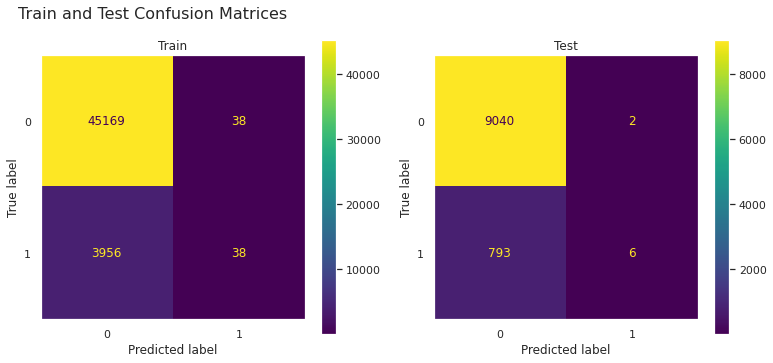

____________________________________________________________________________________________________


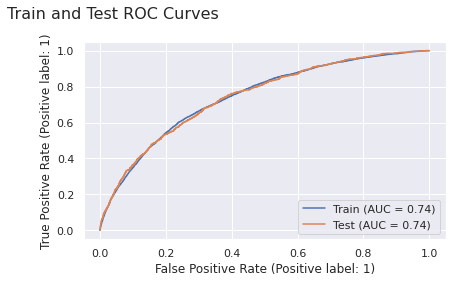

____________________________________________________________________________________________________

AUC-ROC Scores:
---------------
TRAIN: 0.7434
 TEST: 0.7435
____________________________________________________________________________________________________


In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.2,
                                                    test_size=0.04, 
                                                    random_state=42, 
                                                    stratify=y)
#=====================================================================================

pipe_lr = Pipeline([('transformer', transformer), 
                    ('lr', LogisticRegression(random_state=42, max_iter=500, n_jobs=-1))])

pipe_lr.fit(X_train, y_train)

show_metrics_of(pipe_lr, X_train, X_test, y_train, y_test)

Vemos que de fato anteriormente havíamos alcançado um limite na modelagem.

Incluindo mais features resultou em um ganho de 0.1 na pontuação. Isso em um modelo menos complexo como a regressão logística.

In [114]:
dump(pipe_lr, './models/pipe_lr.joblib')

['./models/pipe_lr.joblib']

### Árevore de Decisão

____________________________________________________________________________________________________


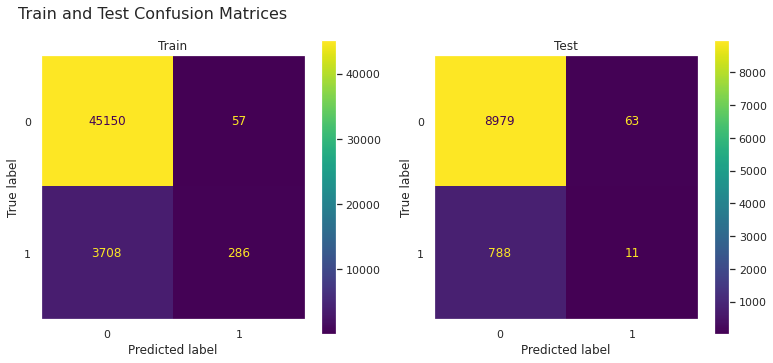

____________________________________________________________________________________________________


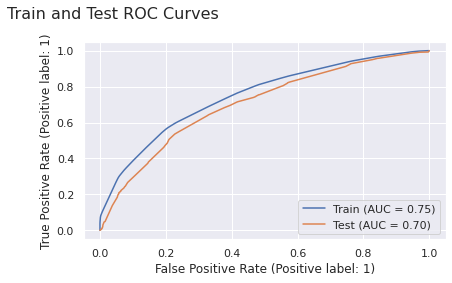

____________________________________________________________________________________________________

AUC-ROC Scores:
---------------
TRAIN: 0.7478
 TEST: 0.7022
____________________________________________________________________________________________________


In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.2,
                                                    test_size=0.04, 
                                                    random_state=42, 
                                                    stratify=y)
#=====================================================================================

pipe_dt = Pipeline([('transformer', transformer), 
                    ('dt', DecisionTreeClassifier(max_depth=8, random_state=42))])

pipe_dt.fit(X_train, y_train)

show_metrics_of(pipe_dt, X_train, X_test, y_train, y_test)

Com uma única árvore, houve uma diminuição na pontuação. Aqui não fizemos otimização de hiperparâmetros por falta de tempo mesmo.

In [113]:
dump(pipe_dt, './models/pipe_dt.joblib')

['./models/pipe_dt.joblib']

### RandonForest

____________________________________________________________________________________________________


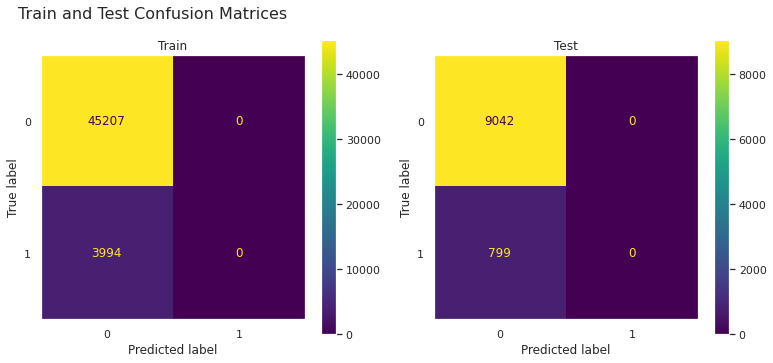

____________________________________________________________________________________________________


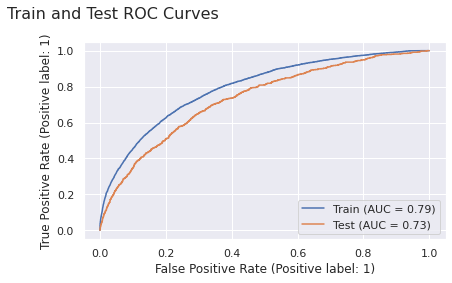

____________________________________________________________________________________________________

AUC-ROC Scores:
---------------
TRAIN: 0.7944
 TEST: 0.7331
____________________________________________________________________________________________________


In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.2,
                                                    test_size=0.04, 
                                                    random_state=42, 
                                                    stratify=y)
#=====================================================================================

pipe_rf = Pipeline([('transformer', transformer), 
                    ('rf', RandomForestClassifier(max_depth=7, random_state=42, n_jobs=-1))])

pipe_rf.fit(X_train, y_train)

show_metrics_of(pipe_rf, X_train, X_test, y_train, y_test)

In [115]:
dump(pipe_rf, './models/pipe_rf.joblib')

['./models/pipe_rf.joblib']

### Adaptative Boosting

____________________________________________________________________________________________________


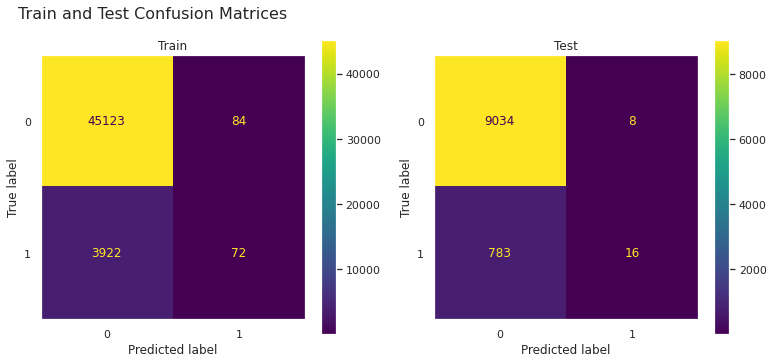

____________________________________________________________________________________________________


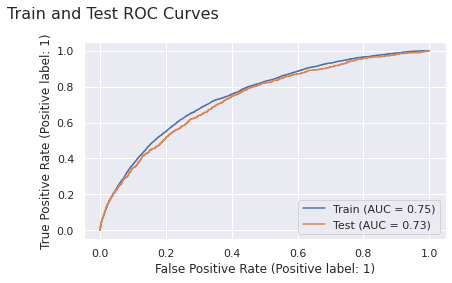

____________________________________________________________________________________________________

AUC-ROC Scores:
---------------
TRAIN: 0.7508
 TEST: 0.7329
____________________________________________________________________________________________________


In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.2,
                                                    test_size=0.04, 
                                                    random_state=42, 
                                                    stratify=y)
#=====================================================================================

pipe_ab = Pipeline([('transformer', transformer), 
                    ('ab', AdaBoostClassifier(random_state=42))])

pipe_ab.fit(X_train, y_train)

show_metrics_of(pipe_ab, X_train, X_test, y_train, y_test)

In [116]:
dump(pipe_ab, './models/pipe_ab.joblib')

['./models/pipe_ab.joblib']

### Gradient Boosting

____________________________________________________________________________________________________


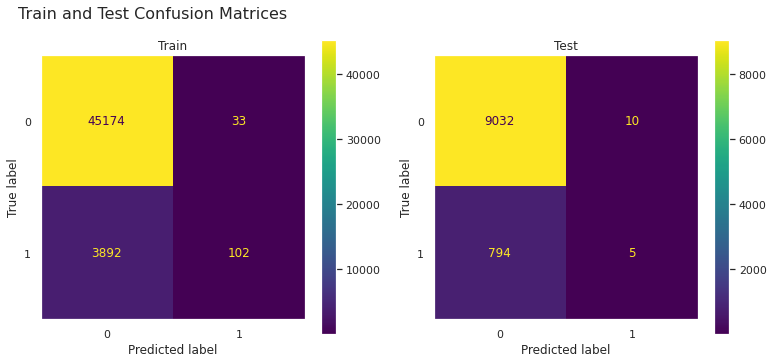

____________________________________________________________________________________________________


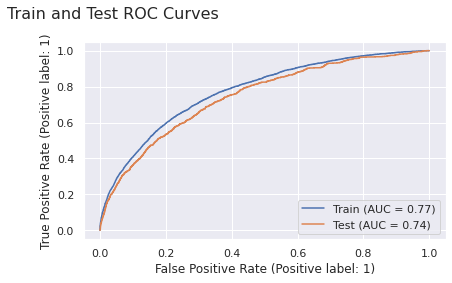

____________________________________________________________________________________________________

AUC-ROC Scores:
---------------
TRAIN: 0.7748
 TEST: 0.7447
____________________________________________________________________________________________________


In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.2,
                                                    test_size=0.04, 
                                                    random_state=42, 
                                                    stratify=y)
#=====================================================================================

pipe_gb = Pipeline([('transformer', transformer), 
                    ('gb', GradientBoostingClassifier(random_state=42))])

pipe_gb.fit(X_train, y_train)

show_metrics_of(pipe_gb, X_train, X_test, y_train, y_test)

In [117]:
dump(pipe_gb, './models/pipe_gb.joblib')

['./models/pipe_gb.joblib']

#### Gradient Boosting: buscando hiperparâmetros

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.2,
                                                    test_size=0.04, 
                                                    random_state=42, 
                                                    stratify=y)
#=====================================================================================

spliter = StratifiedKFold(shuffle=True, random_state=42)

pipe_gb = Pipeline([('transformer', transformer), 
                    ('gb', GradientBoostingClassifier(random_state=42))])

params_grid_gb = {
    'gb__loss': ['deviance', 'exponential'],
    'gb__n_estimators': range(200, 601),
    'gb__learning_rate': np.linspace(0.01, 0.1, 10),
    'gb__criterion' : ['friedman_mse', 'squared_error'],
    'gb__max_depth' : range(1, 5)
}

grid_gb = RandomizedSearchCV(estimator=pipe_gb, 
                             param_distributions=params_grid_gb, 
                             scoring='roc_auc', 
                             cv=splitter, 
                             n_iter=30,
                             n_jobs=-1,
                             verbose=2)

grid_gb.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(transformers=[('num_const_transf',
                                                                               Pipeline(steps=[('inputer',
                                                                                                SimpleImputer(fill_value=-1,
                                                                                                              strategy='constant')),
                                                                                               ('scaler',
                                                                                                MinMaxScaler(clip=True,
                                                                                                             feature_range=(-1,
                                       

[CV] END gb__criterion=friedman_mse, gb__learning_rate=0.05000000000000001, gb__loss=deviance, gb__max_depth=4, gb__n_estimators=274; total time= 4.2min
[CV] END gb__criterion=friedman_mse, gb__learning_rate=0.06000000000000001, gb__loss=deviance, gb__max_depth=3, gb__n_estimators=548; total time= 6.1min
[CV] END gb__criterion=friedman_mse, gb__learning_rate=0.020000000000000004, gb__loss=deviance, gb__max_depth=3, gb__n_estimators=576; total time= 6.3min
[CV] END gb__criterion=squared_error, gb__learning_rate=0.01, gb__loss=exponential, gb__max_depth=2, gb__n_estimators=511; total time= 3.8min
[CV] END gb__criterion=friedman_mse, gb__learning_rate=0.06000000000000001, gb__loss=exponential, gb__max_depth=2, gb__n_estimators=358; total time= 2.7min
[CV] END gb__criterion=friedman_mse, gb__learning_rate=0.09000000000000001, gb__loss=deviance, gb__max_depth=4, gb__n_estimators=375; total time= 5.5min
[CV] END gb__criterion=squared_error, gb__learning_rate=0.1, gb__loss=exponential, gb__ma

[CV] END gb__criterion=friedman_mse, gb__learning_rate=0.05000000000000001, gb__loss=deviance, gb__max_depth=4, gb__n_estimators=274; total time= 4.0min
[CV] END gb__criterion=friedman_mse, gb__learning_rate=0.06000000000000001, gb__loss=deviance, gb__max_depth=3, gb__n_estimators=548; total time= 5.8min
[CV] END gb__criterion=squared_error, gb__learning_rate=0.05000000000000001, gb__loss=exponential, gb__max_depth=1, gb__n_estimators=345; total time= 1.3min
[CV] END gb__criterion=friedman_mse, gb__learning_rate=0.020000000000000004, gb__loss=deviance, gb__max_depth=3, gb__n_estimators=576; total time= 6.4min
[CV] END gb__criterion=friedman_mse, gb__learning_rate=0.09000000000000001, gb__loss=deviance, gb__max_depth=4, gb__n_estimators=284; total time= 4.0min
[CV] END gb__criterion=friedman_mse, gb__learning_rate=0.06000000000000001, gb__loss=exponential, gb__max_depth=2, gb__n_estimators=358; total time= 2.6min
[CV] END gb__criterion=squared_error, gb__learning_rate=0.1, gb__loss=devi

[CV] END gb__criterion=friedman_mse, gb__learning_rate=0.05000000000000001, gb__loss=deviance, gb__max_depth=4, gb__n_estimators=274; total time= 4.2min
[CV] END gb__criterion=friedman_mse, gb__learning_rate=0.06000000000000001, gb__loss=deviance, gb__max_depth=3, gb__n_estimators=548; total time= 6.0min
[CV] END gb__criterion=squared_error, gb__learning_rate=0.05000000000000001, gb__loss=exponential, gb__max_depth=1, gb__n_estimators=345; total time= 1.3min
[CV] END gb__criterion=squared_error, gb__learning_rate=0.04000000000000001, gb__loss=deviance, gb__max_depth=1, gb__n_estimators=536; total time= 2.0min
[CV] END gb__criterion=squared_error, gb__learning_rate=0.04000000000000001, gb__loss=deviance, gb__max_depth=1, gb__n_estimators=536; total time= 2.0min
[CV] END gb__criterion=squared_error, gb__learning_rate=0.01, gb__loss=exponential, gb__max_depth=2, gb__n_estimators=511; total time= 3.7min
[CV] END gb__criterion=friedman_mse, gb__learning_rate=0.09000000000000001, gb__loss=de

____________________________________________________________________________________________________


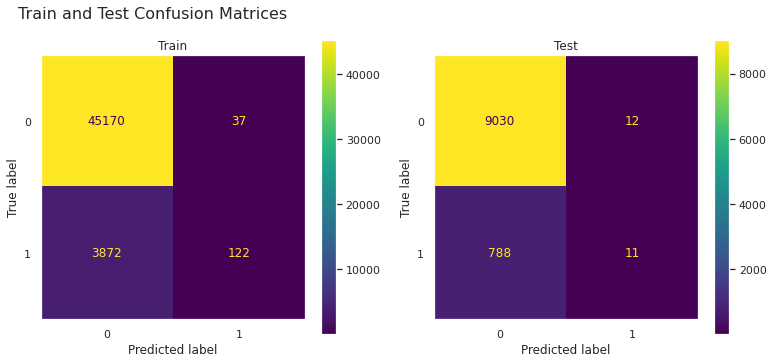

____________________________________________________________________________________________________


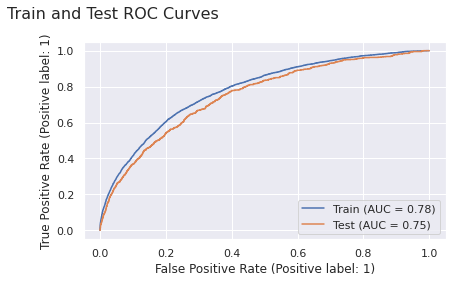

____________________________________________________________________________________________________

AUC-ROC Scores:
---------------
TRAIN: 0.7796
 TEST: 0.7485
____________________________________________________________________________________________________


In [112]:
show_metrics_of(grid_gb, X_train, X_test, y_train, y_test)

In [118]:
dump(grid_gb, './models/grid_gb.joblib')

['./models/grid_gb.joblib']

### Extreme Gradient Boosting

____________________________________________________________________________________________________


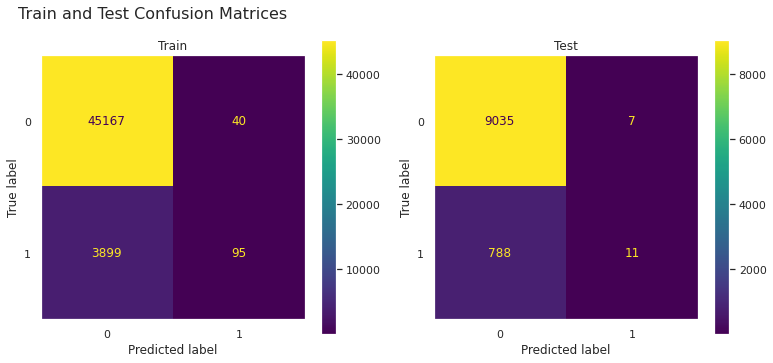

____________________________________________________________________________________________________


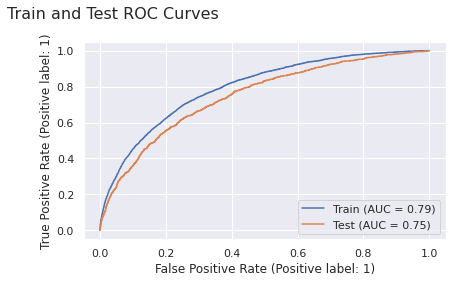

____________________________________________________________________________________________________

AUC-ROC Scores:
---------------
TRAIN: 0.7947
 TEST: 0.7474
____________________________________________________________________________________________________


In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.2,
                                                    test_size=0.04, 
                                                    random_state=42, 
                                                    stratify=y)
#=====================================================================================

pipe_xgb = Pipeline([('transformer', transformer), 
                    ('xgb', XGBClassifier(eval_metric='logloss', random_state=42, reg_alpha=10, max_depth=3))])

pipe_xgb.fit(X_train, y_train)

show_metrics_of(pipe_xgb, X_train, X_test, y_train, y_test)

In [124]:
dump(pipe_xgb, './models/pipe_xgb.joblib')

['./models/pipe_xgb.joblib']

#### Extreme Gradient Boosting: buscando melhores hiperparâmetros

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.2,
                                                    test_size=0.04, 
                                                    random_state=42, 
                                                    stratify=y)
#=====================================================================================

pipe_xgb = Pipeline([('transformer', transformer), 
                    ('xgb', XGBClassifier(eval_metric='logloss', random_state=42))])

params_grid_xgb = {
    'xgb__n_estimators': range(100, 601),
    'xgb__learning_rate': np.linspace(0.1, 1, 10),
    'xgb__reg_alpha' : range(0, 21, 2),
    'xgb__max_depth' : range(1, 6)
}

grid_xgb = RandomizedSearchCV(estimator=pipe_xgb, 
                             param_distributions=params_grid_xgb, 
                             scoring='roc_auc', 
                             cv=splitter, 
                             n_iter=30,
                             n_jobs=-1,
                             verbose=2)

grid_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarni

/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarni

/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarni

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(transformers=[('num_const_transf',
                                                                               Pipeline(steps=[('inputer',
                                                                                                SimpleImputer(fill_value=-1,
                                                                                                              strategy='constant')),
                                                                                               ('scaler',
                                                                                                MinMaxScaler(clip=True,
                                                                                                             feature_range=(-1,
                                       

/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarni

[CV] END xgb__learning_rate=0.9, xgb__max_depth=4, xgb__n_estimators=475, xgb__reg_alpha=0; total time=   0.0s
[CV] END xgb__learning_rate=0.9, xgb__max_depth=4, xgb__n_estimators=475, xgb__reg_alpha=0; total time=   0.0s
[CV] END xgb__learning_rate=0.6, xgb__max_depth=1, xgb__n_estimators=233, xgb__reg_alpha=2; total time=   0.0s
[CV] END xgb__learning_rate=0.6, xgb__max_depth=1, xgb__n_estimators=233, xgb__reg_alpha=2; total time=   0.0s
[CV] END xgb__learning_rate=0.7000000000000001, xgb__max_depth=1, xgb__n_estimators=247, xgb__reg_alpha=10; total time=   0.0s
[CV] END xgb__learning_rate=0.5, xgb__max_depth=2, xgb__n_estimators=102, xgb__reg_alpha=14; total time=   0.0s
[CV] END xgb__learning_rate=1.0, xgb__max_depth=3, xgb__n_estimators=182, xgb__reg_alpha=12; total time=   0.0s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=532, xgb__reg_alpha=12; total time=   0.0s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=532, xgb__reg_alpha=12; 

/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarni

[CV] END xgb__learning_rate=0.6, xgb__max_depth=3, xgb__n_estimators=467, xgb__reg_alpha=6; total time=   0.0s
[CV] END xgb__learning_rate=0.9, xgb__max_depth=4, xgb__n_estimators=475, xgb__reg_alpha=0; total time=   0.1s
[CV] END xgb__learning_rate=0.6, xgb__max_depth=1, xgb__n_estimators=233, xgb__reg_alpha=2; total time=   0.0s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=2, xgb__n_estimators=426, xgb__reg_alpha=4; total time=   0.0s
[CV] END xgb__learning_rate=0.5, xgb__max_depth=2, xgb__n_estimators=102, xgb__reg_alpha=14; total time=   0.0s
[CV] END xgb__learning_rate=0.4, xgb__max_depth=2, xgb__n_estimators=417, xgb__reg_alpha=10; total time=   0.0s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=555, xgb__reg_alpha=0; total time=   0.0s
[CV] END xgb__learning_rate=0.6, xgb__max_depth=3, xgb__n_estimators=546, xgb__reg_alpha=18; total time=   0.0s
[CV] END xgb__learning_rate=0.6, xgb__max_depth=3, xgb__n_estimators=546, xgb__reg_alpha=18; total time=   0.

/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END xgb__learning_rate=0.6, xgb__max_depth=3, xgb__n_estimators=467, xgb__reg_alpha=6; total time=   0.0s
[CV] END xgb__learning_rate=0.5, xgb__max_depth=4, xgb__n_estimators=216, xgb__reg_alpha=16; total time=   0.0s
[CV] END xgb__learning_rate=0.6, xgb__max_depth=1, xgb__n_estimators=233, xgb__reg_alpha=2; total time=   0.0s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=2, xgb__n_estimators=426, xgb__reg_alpha=4; total time=   0.0s
[CV] END xgb__learning_rate=0.5, xgb__max_depth=2, xgb__n_estimators=102, xgb__reg_alpha=14; total time=   0.0s
[CV] END xgb__learning_rate=1.0, xgb__max_depth=3, xgb__n_estimators=182, xgb__reg_alpha=12; total time=   0.0s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=555, xgb__reg_alpha=0; total time=   0.0s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=555, xgb__reg_alpha=0; total time=   0.0s
[CV] END xgb__learning_rate=0.30000000000000004, xgb__max_depth=3, xgb__n_estimators=253, xgb__reg_alpha=2; t

/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarni

[CV] END xgb__learning_rate=0.6, xgb__max_depth=3, xgb__n_estimators=467, xgb__reg_alpha=6; total time=   0.0s
[CV] END xgb__learning_rate=0.5, xgb__max_depth=4, xgb__n_estimators=216, xgb__reg_alpha=16; total time=   0.0s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=2, xgb__n_estimators=426, xgb__reg_alpha=4; total time=   0.0s
[CV] END xgb__learning_rate=0.7000000000000001, xgb__max_depth=1, xgb__n_estimators=247, xgb__reg_alpha=10; total time=   0.0s
[CV] END xgb__learning_rate=0.4, xgb__max_depth=2, xgb__n_estimators=417, xgb__reg_alpha=10; total time=   0.0s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=555, xgb__reg_alpha=0; total time=   0.0s
[CV] END xgb__learning_rate=0.30000000000000004, xgb__max_depth=4, xgb__n_estimators=268, xgb__reg_alpha=2; total time=   0.0s
[CV] END xgb__learning_rate=0.30000000000000004, xgb__max_depth=4, xgb__n_estimators=268, xgb__reg_alpha=2; total time=   0.0s
[CV] END xgb__learning_rate=0.8, xgb__max_depth=4, xgb__n_esti

/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END xgb__learning_rate=0.6, xgb__max_depth=3, xgb__n_estimators=467, xgb__reg_alpha=6; total time=   0.0s
[CV] END xgb__learning_rate=0.5, xgb__max_depth=4, xgb__n_estimators=216, xgb__reg_alpha=16; total time=   0.1s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=2, xgb__n_estimators=426, xgb__reg_alpha=4; total time=   0.0s
[CV] END xgb__learning_rate=0.7000000000000001, xgb__max_depth=1, xgb__n_estimators=247, xgb__reg_alpha=10; total time=   0.0s
[CV] END xgb__learning_rate=0.4, xgb__max_depth=2, xgb__n_estimators=417, xgb__reg_alpha=10; total time=   0.0s
[CV] END xgb__learning_rate=1.0, xgb__max_depth=3, xgb__n_estimators=182, xgb__reg_alpha=12; total time=   0.0s
[CV] END xgb__learning_rate=0.30000000000000004, xgb__max_depth=4, xgb__n_estimators=268, xgb__reg_alpha=2; total time=   0.0s
[CV] END xgb__learning_rate=0.30000000000000004, xgb__max_depth=4, xgb__n_estimators=268, xgb__reg_alpha=2; total time=   0.0s
[CV] END xgb__learning_rate=0.8, xgb__max_depth=4, xgb__n_est

/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarni

[CV] END xgb__learning_rate=0.6, xgb__max_depth=3, xgb__n_estimators=467, xgb__reg_alpha=6; total time=   0.0s
[CV] END xgb__learning_rate=0.6, xgb__max_depth=1, xgb__n_estimators=233, xgb__reg_alpha=2; total time=   0.0s
[CV] END xgb__learning_rate=0.7000000000000001, xgb__max_depth=1, xgb__n_estimators=247, xgb__reg_alpha=10; total time=   0.0s
[CV] END xgb__learning_rate=0.4, xgb__max_depth=2, xgb__n_estimators=417, xgb__reg_alpha=10; total time=   0.0s
[CV] END xgb__learning_rate=1.0, xgb__max_depth=3, xgb__n_estimators=182, xgb__reg_alpha=12; total time=   0.0s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=532, xgb__reg_alpha=12; total time=   0.0s
[CV] END xgb__learning_rate=0.30000000000000004, xgb__max_depth=4, xgb__n_estimators=268, xgb__reg_alpha=2; total time=   0.0s
[CV] END xgb__learning_rate=0.8, xgb__max_depth=4, xgb__n_estimators=420, xgb__reg_alpha=20; total time=   0.0s
[CV] END xgb__learning_rate=0.8, xgb__max_depth=4, xgb__n_estimators=420, xg

/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/godara/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarni

In [128]:
grid_xgb.best_params_

{'xgb__reg_alpha': 4,
 'xgb__n_estimators': 389,
 'xgb__max_depth': 1,
 'xgb__learning_rate': 0.4}

____________________________________________________________________________________________________


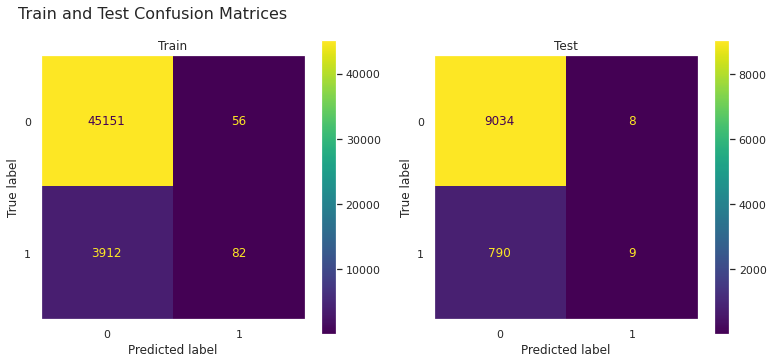

____________________________________________________________________________________________________


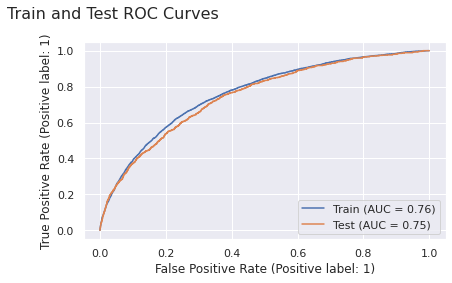

____________________________________________________________________________________________________

AUC-ROC Scores:
---------------
TRAIN: 0.7625
 TEST: 0.7483
____________________________________________________________________________________________________


In [130]:
show_metrics_of(grid_xgb, X_train, X_test, y_train, y_test)

In [131]:
dump(grid_xgb, './models/grid_xgb.joblib')

['./models/grid_xgb.joblib']

### Naive Bayes

____________________________________________________________________________________________________


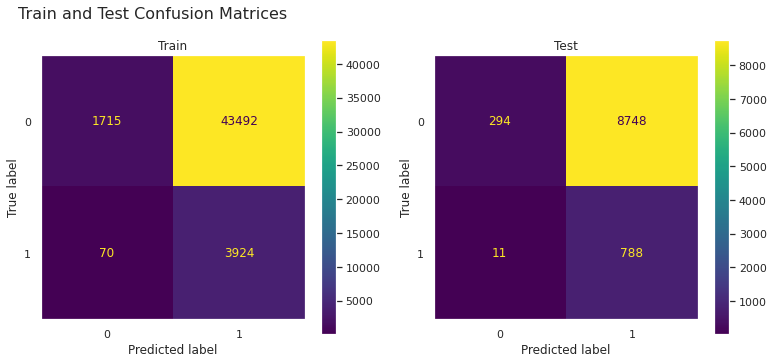

____________________________________________________________________________________________________


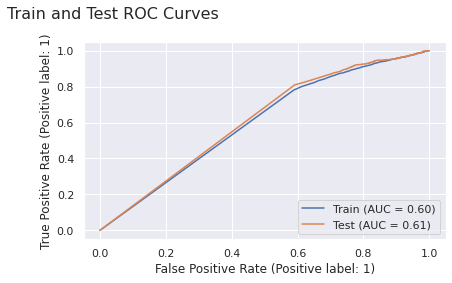

____________________________________________________________________________________________________

AUC-ROC Scores:
---------------
TRAIN: 0.6008
 TEST: 0.6125
____________________________________________________________________________________________________


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.2,
                                                    test_size=0.04, 
                                                    random_state=42, 
                                                    stratify=y)
#=====================================================================================

pipe_gnb = Pipeline([('transformer', transformer), 
                    ('gnb', GaussianNB())])

pipe_gnb.fit(X_train, y_train)

show_metrics_of(pipe_gnb, X_train, X_test, y_train, y_test)

### SVM

____________________________________________________________________________________________________


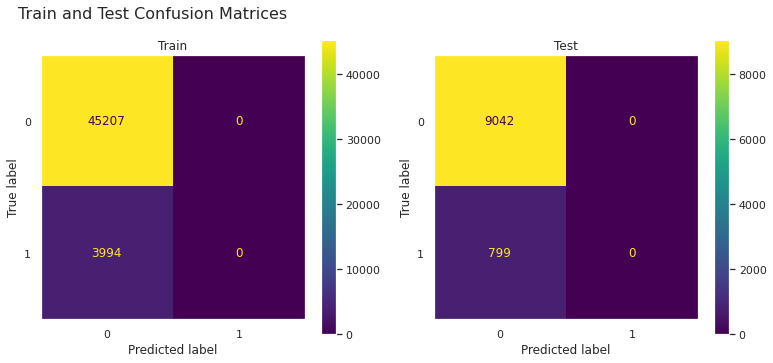

____________________________________________________________________________________________________


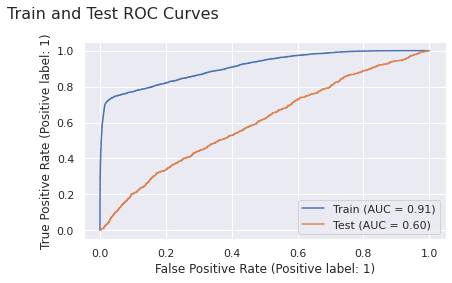

____________________________________________________________________________________________________

AUC-ROC Scores:
---------------
TRAIN: 0.9112
 TEST: 0.6006
____________________________________________________________________________________________________


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.2,
                                                    test_size=0.04, 
                                                    random_state=42, 
                                                    stratify=y)
#=====================================================================================

pipe_svc = Pipeline([('transformer', transformer), 
                    ('svc', SVC(random_state=42, probability=True))])

pipe_svc.fit(X_train, y_train)

show_metrics_of(pipe_svc, X_train, X_test, y_train, y_test)

## Avaliação Final

Até aqui usamos apenas 20% dos dados para treino.

Agora vamos rodar os melhores modelos na base "toda" considerando as variáveis utlizadas até aqui.

In [32]:
X = X_df[X.columns]

In [33]:
from joblib import load

### GBoosting

In [43]:
grid_gb = load('./models/grid_gb.joblib')
grid_gb.best_estimator_['gb']

GradientBoostingClassifier(max_depth=2, n_estimators=337, random_state=42)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)
#=====================================================================================

pipe_best_gb = Pipeline([('transformer', transformer), 
                         ('best_gb', GradientBoostingClassifier(max_depth=2, 
                                                                n_estimators=337, 
                                                                random_state=42))])

pipe_best_gb.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num_const_transf',
                                                  Pipeline(steps=[('inputer',
                                                                   SimpleImputer(fill_value=-1,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   MinMaxScaler(clip=True,
                                                                                feature_range=(-1,
                                                                                               1)))]),
                                                  ['FLAG_MOBIL',
                                                   'FLAG_EMP_PHONE',
                                                   'FLAG_WORK_PHONE',
                                              

____________________________________________________________________________________________________


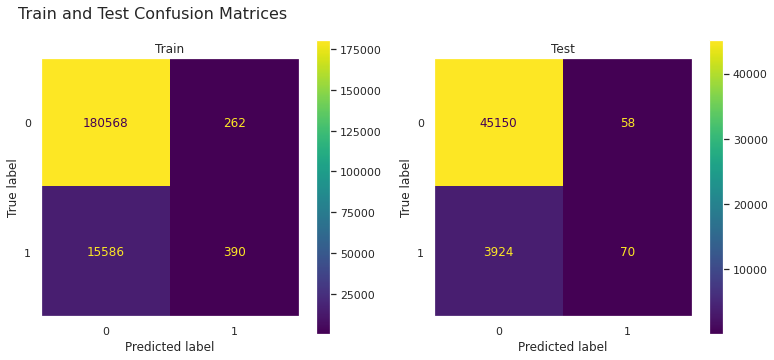

____________________________________________________________________________________________________


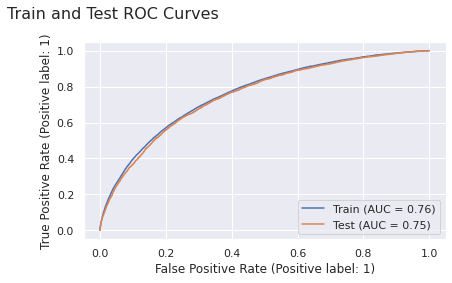

____________________________________________________________________________________________________

AUC-ROC Scores:
---------------
TRAIN: 0.7620
 TEST: 0.7533
____________________________________________________________________________________________________


In [47]:
show_metrics_of(pipe_best_gb, X_train, X_test, y_train, y_test)

### XGBossting

In [49]:
grid_xgb = load('./models/grid_xgb.joblib')

In [53]:
grid_xgb.best_estimator_['xgb']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.4, max_delta_step=0,
              max_depth=1, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=389, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=4, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)
#=====================================================================================

pipe_best_xgb = Pipeline([('transformer', transformer), 
                         ('best_xgb', grid_xgb.best_estimator_['xgb'])])

pipe_best_xgb.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num_const_transf',
                                                  Pipeline(steps=[('inputer',
                                                                   SimpleImputer(fill_value=-1,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   MinMaxScaler(clip=True,
                                                                                feature_range=(-1,
                                                                                               1)))]),
                                                  ['FLAG_MOBIL',
                                                   'FLAG_EMP_PHONE',
                                                   'FLAG_WORK_PHONE',
                                              

____________________________________________________________________________________________________


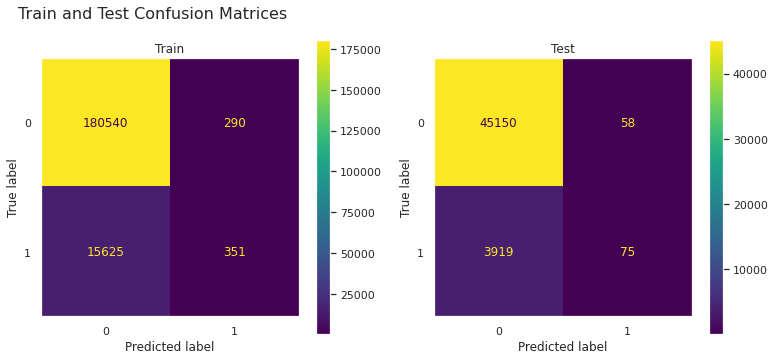

____________________________________________________________________________________________________


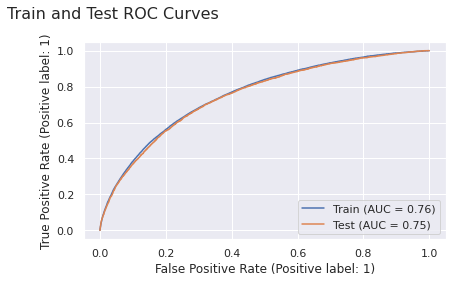

____________________________________________________________________________________________________

AUC-ROC Scores:
---------------
TRAIN: 0.7573
 TEST: 0.7512
____________________________________________________________________________________________________


In [55]:
show_metrics_of(pipe_best_xgb, X_train, X_test, y_train, y_test)

### Considerações

Dos estimadores que treinamos com parte dos dados, retreinamos os dois melhores com as mesmas configurações mas agora com a base toda.

No nosso caso, a melhor pontuação foi obtida pelo *Gradient Boosting*.

Portanto, este será nosso modelo escolido para fazer as predições na base de teste.

## Aplicando o modelo nos dados de teste

In [65]:
df_test = pd.read_csv('./data/application_test_student.csv')
df_test

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,149741,Cash loans,F,N,N,0,"117,000.000000","417,024.000000","20,191.500000","360,000.000000",...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
1,363290,Cash loans,M,N,Y,0,"450,000.000000","640,080.000000","31,261.500000","450,000.000000",...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2,436006,Revolving loans,M,Y,Y,0,"450,000.000000","900,000.000000","45,000.000000","900,000.000000",...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
3,377703,Cash loans,M,Y,N,1,"360,000.000000","1,125,000.000000","33,025.500000","1,125,000.000000",...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
4,188624,Cash loans,M,Y,Y,0,"675,000.000000","835,380.000000","42,840.000000","675,000.000000",...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61498,102817,Cash loans,M,Y,N,0,"225,000.000000","472,500.000000","46,161.000000","454,500.000000",...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
61499,343961,Cash loans,M,N,Y,0,"112,500.000000","508,495.500000","24,592.500000","454,500.000000",...,0,0,0,0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
61500,427828,Cash loans,F,Y,Y,0,"157,500.000000","808,650.000000","23,643.000000","675,000.000000",...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
61501,405956,Cash loans,F,N,Y,0,"202,500.000000","590,337.000000","30,271.500000","477,000.000000",...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [69]:
df_ids = df_test[['SK_ID_CURR']]

In [70]:
X.columns

Index(['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CN

In [71]:
df_test = df_test[X.columns]

In [72]:
df_test

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,Cash loans,N,N,0,"117,000.000000","417,024.000000","20,191.500000","360,000.000000","Spouse, partner",Working,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
1,Cash loans,N,Y,0,"450,000.000000","640,080.000000","31,261.500000","450,000.000000",Unaccompanied,Commercial associate,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2,Revolving loans,Y,Y,0,"450,000.000000","900,000.000000","45,000.000000","900,000.000000",Unaccompanied,Commercial associate,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
3,Cash loans,Y,N,1,"360,000.000000","1,125,000.000000","33,025.500000","1,125,000.000000",Unaccompanied,Working,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
4,Cash loans,Y,Y,0,"675,000.000000","835,380.000000","42,840.000000","675,000.000000",Unaccompanied,Working,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61498,Cash loans,Y,N,0,"225,000.000000","472,500.000000","46,161.000000","454,500.000000",Unaccompanied,Working,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
61499,Cash loans,N,Y,0,"112,500.000000","508,495.500000","24,592.500000","454,500.000000","Spouse, partner",Pensioner,...,0,0,0,0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
61500,Cash loans,Y,Y,0,"157,500.000000","808,650.000000","23,643.000000","675,000.000000",Unaccompanied,Pensioner,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
61501,Cash loans,N,Y,0,"202,500.000000","590,337.000000","30,271.500000","477,000.000000",Unaccompanied,Commercial associate,...,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


In [73]:
df_proba = pd.DataFrame(pipe_best_gb.predict_proba(df_test)[:, 1], columns=['PRED_PROBA'])

In [74]:
df_result = pd.concat([df_ids, df_proba], axis=1)
df_result

,SK_ID_CURR,PRED_PROBA
0,149741,0.297650
1,363290,0.041124
2,436006,0.060796
3,377703,0.044426
4,188624,0.306783
...,...,...
61498,102817,0.082735
61499,343961,0.076535
61500,427828,0.040068
61501,405956,0.072663


In [75]:
df_result.to_csv('./data/test_probas.csv')